# Undersampling

In [1]:
# importation des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# chargement des donnees
data = pd.read_csv("Clean_Medicl_cost.csv")
data.head()

age  sex     bmi  children  smoker    region      charges
0  19.0    0  27.900       0.0       1  0.243082  16884.92400
1  18.0    1  33.770       1.0       0  0.272251   1725.55230
2  28.0    1  33.000       3.0       0  0.272251   4449.46200
3  33.0    1  22.705       0.0       0  0.242334  21984.47061
4  32.0    1  28.880       0.0       0  0.242334   3866.85520

# Fonctions d'entrainements des modeles

## Random forest

In [3]:
## FONCTION D'ENTRAINEMENT ##
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

def random_Forest_Train(X_train, y_train):

    # INITIALISATION ET ENTRAINEMENT
    Random_forest = RandomForestClassifier(max_depth= 2) # reduction de la profondeur de l'abre pour empeche l'overfit (nombre trop bas de donnees)
    Random_forest.fit(X_train,y_train)
    
    # PREDICTION SUR LE TRAIN
    ypredict_train = Random_forest.predict(X_train)

    # DETERMINATION DES METRIQUES
    acc = accuracy_score(y_train,ypredict_train) # accuracy
    conf = confusion_matrix(y_train,ypredict_train) # confusion matrix
    svc_disp = RocCurveDisplay.from_estimator(Random_forest,X_train,y_train) # courbe ROC

    print("Accuracy : ", acc)

    plt.figure(figsize=(8,5))
    sns.heatmap(conf, annot=True)
    plt.title("Matrice de confusion")
    plt.show()

    print(classification_report(y_train,ypredict_train))
    return Random_forest

## Naives bayes

In [4]:
from sklearn.naive_bayes import GaussianNB

## FONCTION D'ENTRAINEMENT ##
def naives_bayes_train(X_train, y_train):
    # ENTRAINEMENT DU MODELE
    naives_bayes =GaussianNB()
    naives_bayes.fit(X_train,y_train)
    ypredict_train=naives_bayes.predict(X_train)

    # DETERMINATION DES METRIQUES
    acc=accuracy_score(y_train,ypredict_train) # accuracy
    conf=confusion_matrix(y_train,ypredict_train) # confusion matrix
    svc_disp=RocCurveDisplay.from_estimator(naives_bayes,X_train,y_train) # courbe ROC

    print("Accuracy : ", acc)

    plt.figure(figsize=(5,5))
    sns.heatmap(conf, annot=True)
    plt.title("Matrice de confusion")
    plt.show()

    print(classification_report(y_train,ypredict_train))
    return naives_bayes

## Xgboost

In [5]:
##  ENTREINEMENT DU MODELE ##

import xgboost as xgb
from sklearn.metrics import roc_curve, auc

def xgboost_train(X_train, y_train):
    D_train=xgb.DMatrix(X_train,label=y_train)
    param={'eta':0.3,'max_depth':2,'objective':'multi:softprob','num_class':2}
    steps = 20 # nombre de passage d'aprentissage
    xgboost_model = xgb.train(param,D_train,steps)
    ypredict_train=xgboost_model.predict(D_train)
    # Si les prédictions sont des probabilités, les convertir en labels de classe
    if ypredict_train.ndim > 1:
        ypredict_train = np.argmax(ypredict_train, axis=1)

    # DETERMINATION DES METRIQUES
    acc = accuracy_score(y_train,ypredict_train) # accuracy
    conf = confusion_matrix(y_train,ypredict_train) # confusion matrix
    
    print("Accuracy : ", acc)
    
    ypredict_train_proba = xgboost_model.predict(D_train)[:,1]
    fpr, tpr, _ = roc_curve(y_train, ypredict_train_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure(figsize=(8,5))
    sns.heatmap(conf, annot=True)
    plt.title("Matrice de confusion")
    plt.show()

    print(classification_report(y_train,ypredict_train))
    return xgboost_model

In [6]:
# preparation des donnees
X = data.drop(columns="smoker")
y = data[["smoker"]]
# isolation train , test
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.25,random_state=123)
# standardisation des donnees 
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# re-equilibrge des donnees

In [7]:
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks
)

undersampler_dict = {
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tl' : TomekLinks(
        sampling_strategy='auto',
        n_jobs=4)
}

In [8]:
# comparaison avant/apres re-equilibrage
def compare_smoker_distribution(original_data, resampled_data, title_suffix=''):
    """
    Compare la répartition des classes fumeurs avant/après sous-échantillonnage.
    Affiche 2 lignes de sous-graphiques pour chaque variable : original (haut), resampled (bas).
    """

    cols_to_plot = ['charges', 'age', 'bmi', 'children', 'sex', 'region']
    n_plots = len(cols_to_plot) + 1  # +1 pour la variable cible "smoker"

    fig, axes = plt.subplots(2, n_plots, figsize=(4 * n_plots, 10))
    
    for ax_row, dataset, label in zip(axes, [original_data, resampled_data], ['Avant', 'Après']):
        # Plot countplot pour 'smoker'
        sns.countplot(data=dataset, x='smoker', ax=ax_row[0])
        ax_row[0].set_title(f"{label} - Fumeur")
        ax_row[0].set_xlabel('Fumeur')
        ax_row[0].set_ylabel('Nombre')

        # Plot les autres colonnes
        for i, col in enumerate(cols_to_plot):
            if dataset[col].dtype == 'object':
                sns.countplot(data=dataset, x=col, hue='smoker', ax=ax_row[i+1])
                ax_row[i+1].set_ylabel('Nombre')
            else:
                sns.kdeplot(data=dataset, x=col, hue='smoker', fill=True, ax=ax_row[i+1])
                ax_row[i+1].set_ylabel('Densité')

            ax_row[i+1].set_title(f"{label} - {col.capitalize()}")
            ax_row[i+1].set_xlabel(col.capitalize())

    plt.suptitle(f'Comparaison Avant/Après UnderSampling {title_suffix}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [9]:
# visualisation des classes apres re-equilibrage 
def compare_pca_oversampling(original_data, resampled_datasets_dict):
    """
    Affiche la projection PCA du jeu original et de chaque jeu sous-échantillonné sur une même ligne.
    """
    from sklearn.decomposition import PCA

    methods = ['Original'] + list(resampled_datasets_dict.keys())
    datasets = [original_data] + list(resampled_datasets_dict.values())

    n_cols = len(datasets)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5))  # 1 ligne

    if n_cols == 1:
        axes = [axes]  # S'assurer que axes est itérable

    for i, (method_name, data) in enumerate(zip(methods, datasets)):
        features = ['age', 'sex', 'bmi', 'children', 'region', 'charges']
        X = data[features]
        y = data['smoker']

        # Encodage et standardisation
        X_encoded = pd.get_dummies(X, drop_first=True)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_encoded)

        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        pca_df['smoker'] = y.values

        # Scatterplot
        sns.scatterplot(
            data=pca_df,
            x='PC1',
            y='PC2',
            hue='smoker',
            palette='Dark2',
            s=50,
            alpha=0.6,
            edgecolor='black',
            ax=axes[i]
        )
        axes[i].set_title(f"PCA - {method_name}")
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")
        axes[i].legend(title="Smoker")

    plt.tight_layout()
    plt.suptitle("Comparaison PCA - Données Originales vs Sous-échantillonnées", fontsize=18, y=1.05)
    plt.show()


In [10]:
# fonction de reequilibrage (Random forest)
def compare_random_forest_performance(X_train_orig, y_train_orig,
                                      X_train_res, y_train_res,
                                      X_test, y_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score, confusion_matrix,
        classification_report, roc_curve, auc
    )

    # Entraînement des deux modèles
    print("=== Entraînement sur données sous-échantillonnées ===")


    model_resampled = random_Forest_Train(X_train_res, y_train_res)

    print("\n=== Entraînement sur données originales ===")
    model_original = random_Forest_Train(X_train_orig, y_train_orig)

    # Test des deux modèles
    ypred_res = model_resampled.predict(X_test)
    ypred_orig = model_original.predict(X_test)

    # ROC probas
    yproba_res = model_resampled.predict_proba(X_test)[:, 1]
    yproba_orig = model_original.predict_proba(X_test)[:, 1]

    # Confusion matrices
    conf_res = confusion_matrix(y_test, ypred_res)
    conf_orig = confusion_matrix(y_test, ypred_orig)

    # Metrics
    report_res = classification_report(y_test, ypred_res, output_dict=True)
    report_orig = classification_report(y_test, ypred_orig, output_dict=True)

    acc_res = accuracy_score(y_test, ypred_res)
    acc_orig = accuracy_score(y_test, ypred_orig)

    # Courbes ROC
    fpr_res, tpr_res, _ = roc_curve(y_test, yproba_res)
    fpr_orig, tpr_orig, _ = roc_curve(y_test, yproba_orig)
    auc_res = auc(fpr_res, tpr_res)
    auc_orig = auc(fpr_orig, tpr_orig)

    # ==== VISUALISATION ====
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    # Matrices de confusion
    sns.heatmap(conf_res, annot=True, fmt='d', ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix - Undersampled")
    sns.heatmap(conf_orig, annot=True, fmt='d', ax=axes[0, 1])
    axes[0, 1].set_title("Confusion Matrix - Original")

    # Accuracy + Rapport Classification
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[1, 0].text(0, 0.5, f"Accuracy: {acc_res:.2f}\n\n" + classification_report(y_test, ypred_res),
                   fontsize=10, va='center')
    axes[1, 1].text(0, 0.5, f"Accuracy: {acc_orig:.2f}\n\n" + classification_report(y_test, ypred_orig),
                   fontsize=10, va='center')
    axes[1, 0].set_title("Rapport - Undersampled")
    
    axes[1, 1].set_title("Rapport - Original")

    # Courbe ROC
    axes[2, 0].plot(fpr_res, tpr_res, label=f'AUC = {auc_res:.2f}')
    axes[2, 1].plot(fpr_orig, tpr_orig, label=f'AUC = {auc_orig:.2f}')
    for ax in axes[2]:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("Taux de faux positifs")
        ax.set_ylabel("Taux de vrais positifs")
        ax.legend()
    
    axes[2, 0].set_title("ROC - Undersampled")
    axes[2, 1].set_title("ROC - Original")

    plt.tight_layout()
    plt.suptitle("Comparaison des performances Random Forest", fontsize=16, y=1.02)
    plt.show()


In [11]:
# fonction de reequilibrage naives bayes
def compare_Naives_bayes_performance(X_train_orig, y_train_orig,
                                      X_train_res, y_train_res,
                                      X_test, y_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score, confusion_matrix,
        classification_report, roc_curve, auc
    )

    # Entraînement des deux modèles
    print("=== Entraînement sur données sous-échantillonnées ===")

    model_resampled = naives_bayes_train(X_train_res, y_train_res)

    print("\n=== Entraînement sur données originales ===")
    model_original = naives_bayes_train(X_train_orig, y_train_orig)

    # Test des deux modèles
    ypred_res = model_resampled.predict(X_test)
    ypred_orig = model_original.predict(X_test)

    # ROC probas
    yproba_res = model_resampled.predict_proba(X_test)[:, 1]
    yproba_orig = model_original.predict_proba(X_test)[:, 1]

    # Confusion matrices
    conf_res = confusion_matrix(y_test, ypred_res)
    conf_orig = confusion_matrix(y_test, ypred_orig)

    # Metrics
    report_res = classification_report(y_test, ypred_res, output_dict=True)
    report_orig = classification_report(y_test, ypred_orig, output_dict=True)

    acc_res = accuracy_score(y_test, ypred_res)
    acc_orig = accuracy_score(y_test, ypred_orig)

    # Courbes ROC
    fpr_res, tpr_res, _ = roc_curve(y_test, yproba_res)
    fpr_orig, tpr_orig, _ = roc_curve(y_test, yproba_orig)
    auc_res = auc(fpr_res, tpr_res)
    auc_orig = auc(fpr_orig, tpr_orig)

    # ==== VISUALISATION ====
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    # Matrices de confusion
    sns.heatmap(conf_res, annot=True, fmt='d', ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix - Undersampled")
    sns.heatmap(conf_orig, annot=True, fmt='d', ax=axes[0, 1])
    axes[0, 1].set_title("Confusion Matrix - Original")

    # Accuracy + Rapport Classification
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[1, 0].text(0, 0.5, f"Accuracy: {acc_res:.2f}\n\n" + classification_report(y_test, ypred_res),
                   fontsize=10, va='center')
    axes[1, 1].text(0, 0.5, f"Accuracy: {acc_orig:.2f}\n\n" + classification_report(y_test, ypred_orig),
                   fontsize=10, va='center')
    axes[1, 0].set_title("Rapport - Undersampled")
    axes[1, 1].set_title("Rapport - Original")

    # Courbe ROC
    axes[2, 0].plot(fpr_res, tpr_res, label=f'AUC = {auc_res:.2f}')
    axes[2, 1].plot(fpr_orig, tpr_orig, label=f'AUC = {auc_orig:.2f}')
    for ax in axes[2]:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("Taux de faux positifs")
        ax.set_ylabel("Taux de vrais positifs")
        ax.legend()
    axes[2, 0].set_title("ROC - Undersampled")
    axes[2, 1].set_title("ROC - Original")

    plt.tight_layout()
    plt.suptitle("Comparaison des performances Naives bayes", fontsize=16, y=1.02)
    plt.show()

In [12]:
# Fonction de reequilibrage Xgboost
def compare_xgboost_performance(X_train_orig, y_train_orig,
                                 X_train_res, y_train_res,
                                 X_test, y_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score, confusion_matrix,
        classification_report, roc_curve, auc
    )

    # Entraînement des deux modèles
    print("=== Entraînement sur données sous-échantillonnées ===")
    model_resampled = xgboost_train(X_train_res, y_train_res)

    print("\n=== Entraînement sur données originales ===")
    model_original = xgboost_train(X_train_orig, y_train_orig)

    # Conversion de X_test en DMatrix pour la prédiction, avec les noms de colonnes
    D_test = xgb.DMatrix(X_test, feature_names=list(X.columns))

    # Prédictions
    yproba_res = model_resampled.predict(D_test)
    yproba_orig = model_original.predict(D_test)

    ypred_res = np.argmax(yproba_res, axis=1)
    ypred_orig = np.argmax(yproba_orig, axis=1)

    # Confusion matrices
    conf_res = confusion_matrix(y_test, ypred_res)
    conf_orig = confusion_matrix(y_test, ypred_orig)

    # Metrics
    acc_res = accuracy_score(y_test, ypred_res)
    acc_orig = accuracy_score(y_test, ypred_orig)

    # Courbes ROC (avec les probabilités de la classe 1)
    fpr_res, tpr_res, _ = roc_curve(y_test, yproba_res[:, 1])
    fpr_orig, tpr_orig, _ = roc_curve(y_test, yproba_orig[:, 1])
    auc_res = auc(fpr_res, tpr_res)
    auc_orig = auc(fpr_orig, tpr_orig)

    # ==== VISUALISATION ====
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    # Matrices de confusion
    sns.heatmap(conf_res, annot=True, fmt='d', ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix - Undersampled")
    sns.heatmap(conf_orig, annot=True, fmt='d', ax=axes[0, 1])
    axes[0, 1].set_title("Confusion Matrix - Original")

    # Accuracy + Rapport Classification
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[1, 0].text(0, 0.5, f"Accuracy: {acc_res:.2f}\n\n" + classification_report(y_test, ypred_res),
                   fontsize=10, va='center')
    axes[1, 1].text(0, 0.5, f"Accuracy: {acc_orig:.2f}\n\n" + classification_report(y_test, ypred_orig),
                   fontsize=10, va='center')
    axes[1, 0].set_title("Rapport - Undersampled")
    axes[1, 1].set_title("Rapport - Original")

    # Courbe ROC
    axes[2, 0].plot(fpr_res, tpr_res, label=f'AUC = {auc_res:.2f}')
    axes[2, 1].plot(fpr_orig, tpr_orig, label=f'AUC = {auc_orig:.2f}')
    for ax in axes[2]:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("Taux de faux positifs")
        ax.set_ylabel("Taux de vrais positifs")
        ax.legend()
    axes[2, 0].set_title("ROC - Undersampled")
    axes[2, 1].set_title("ROC - Original")

    plt.tight_layout()
    plt.suptitle("Comparaison des performances XGBoost", fontsize=16, y=1.02)
    plt.show()


## Random forest
### requilibrage et control de l'impact sur le modeles 

Méthode d'under-sampling :  random


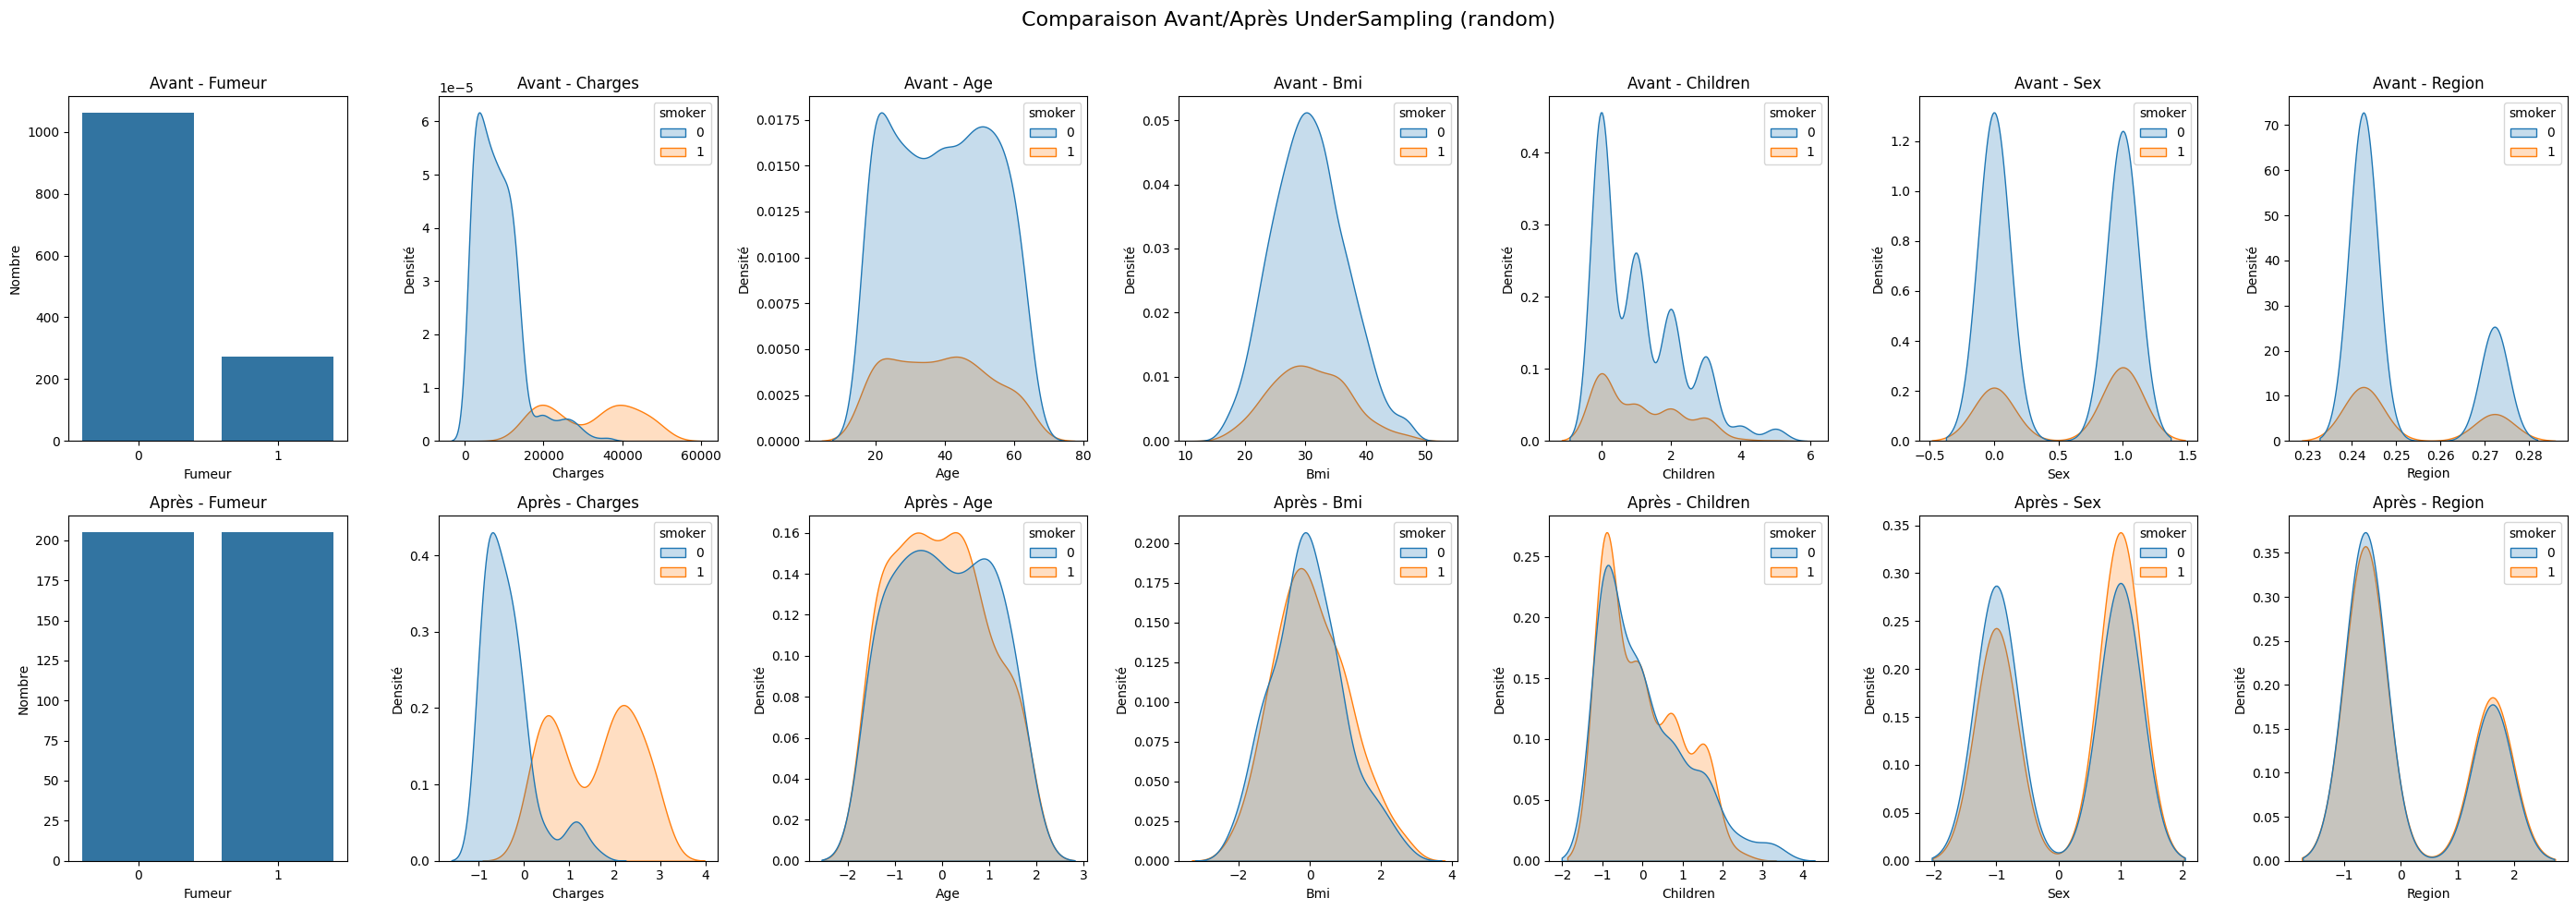

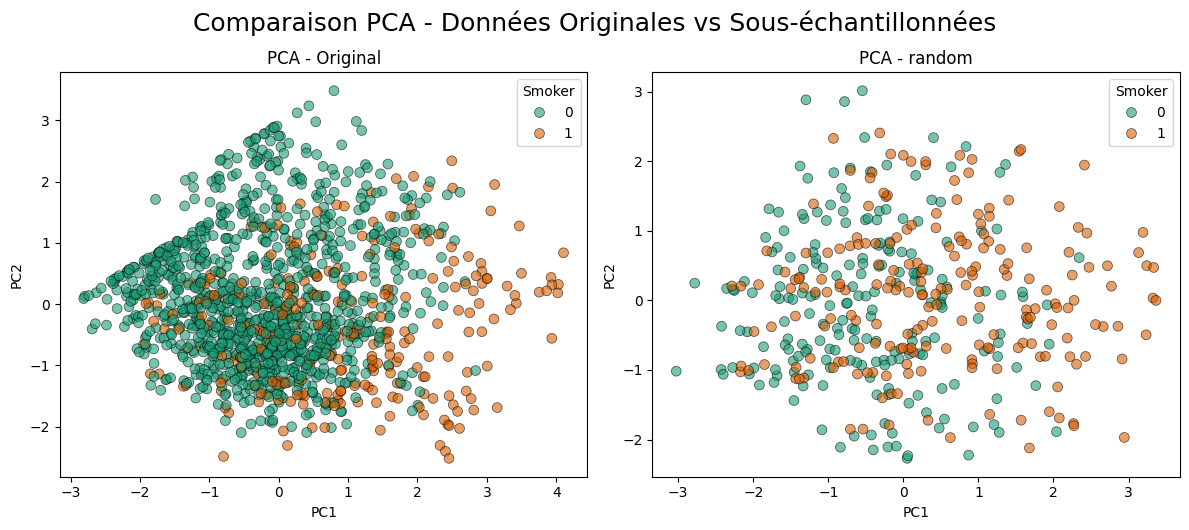


####### COMPARAISON PERFORMANCE - MÉTHODE : RANDOM #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.9365853658536586


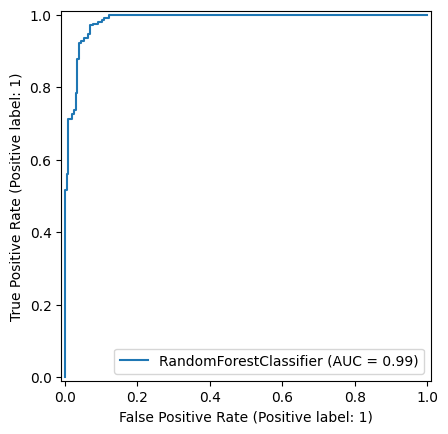

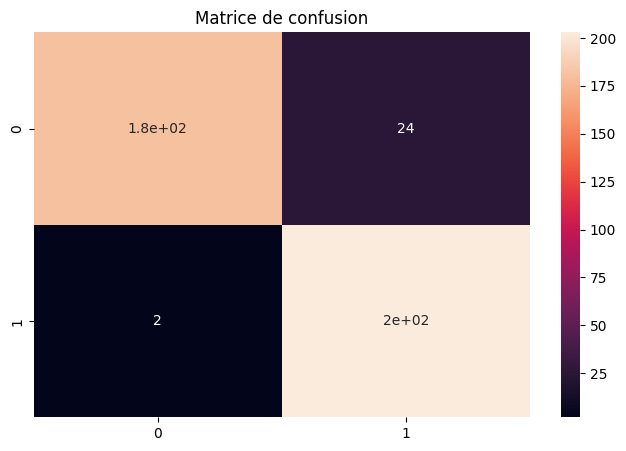

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       205
           1       0.89      0.99      0.94       205

    accuracy                           0.94       410
   macro avg       0.94      0.94      0.94       410
weighted avg       0.94      0.94      0.94       410


=== Entraînement sur données originales ===
Accuracy :  0.8093812375249501


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


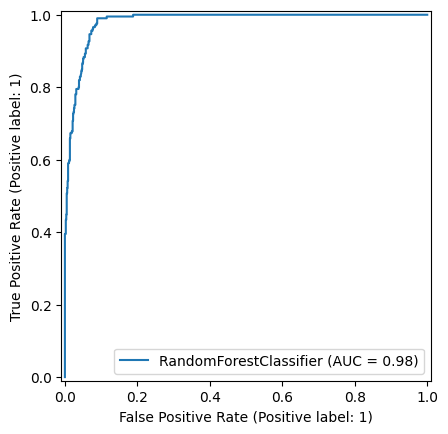

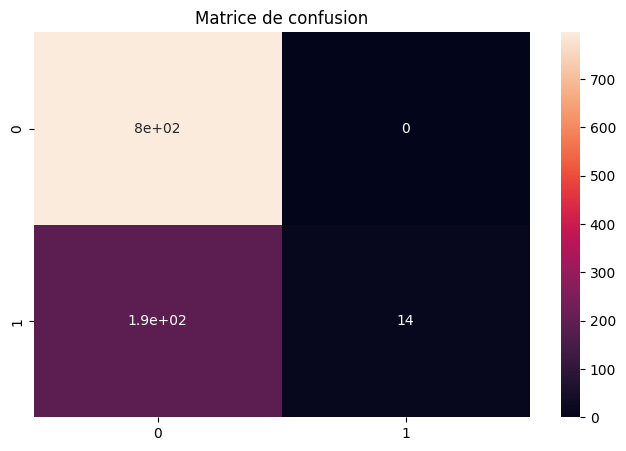

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       797
           1       1.00      0.07      0.13       205

    accuracy                           0.81      1002
   macro avg       0.90      0.53      0.51      1002
weighted avg       0.85      0.81      0.74      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


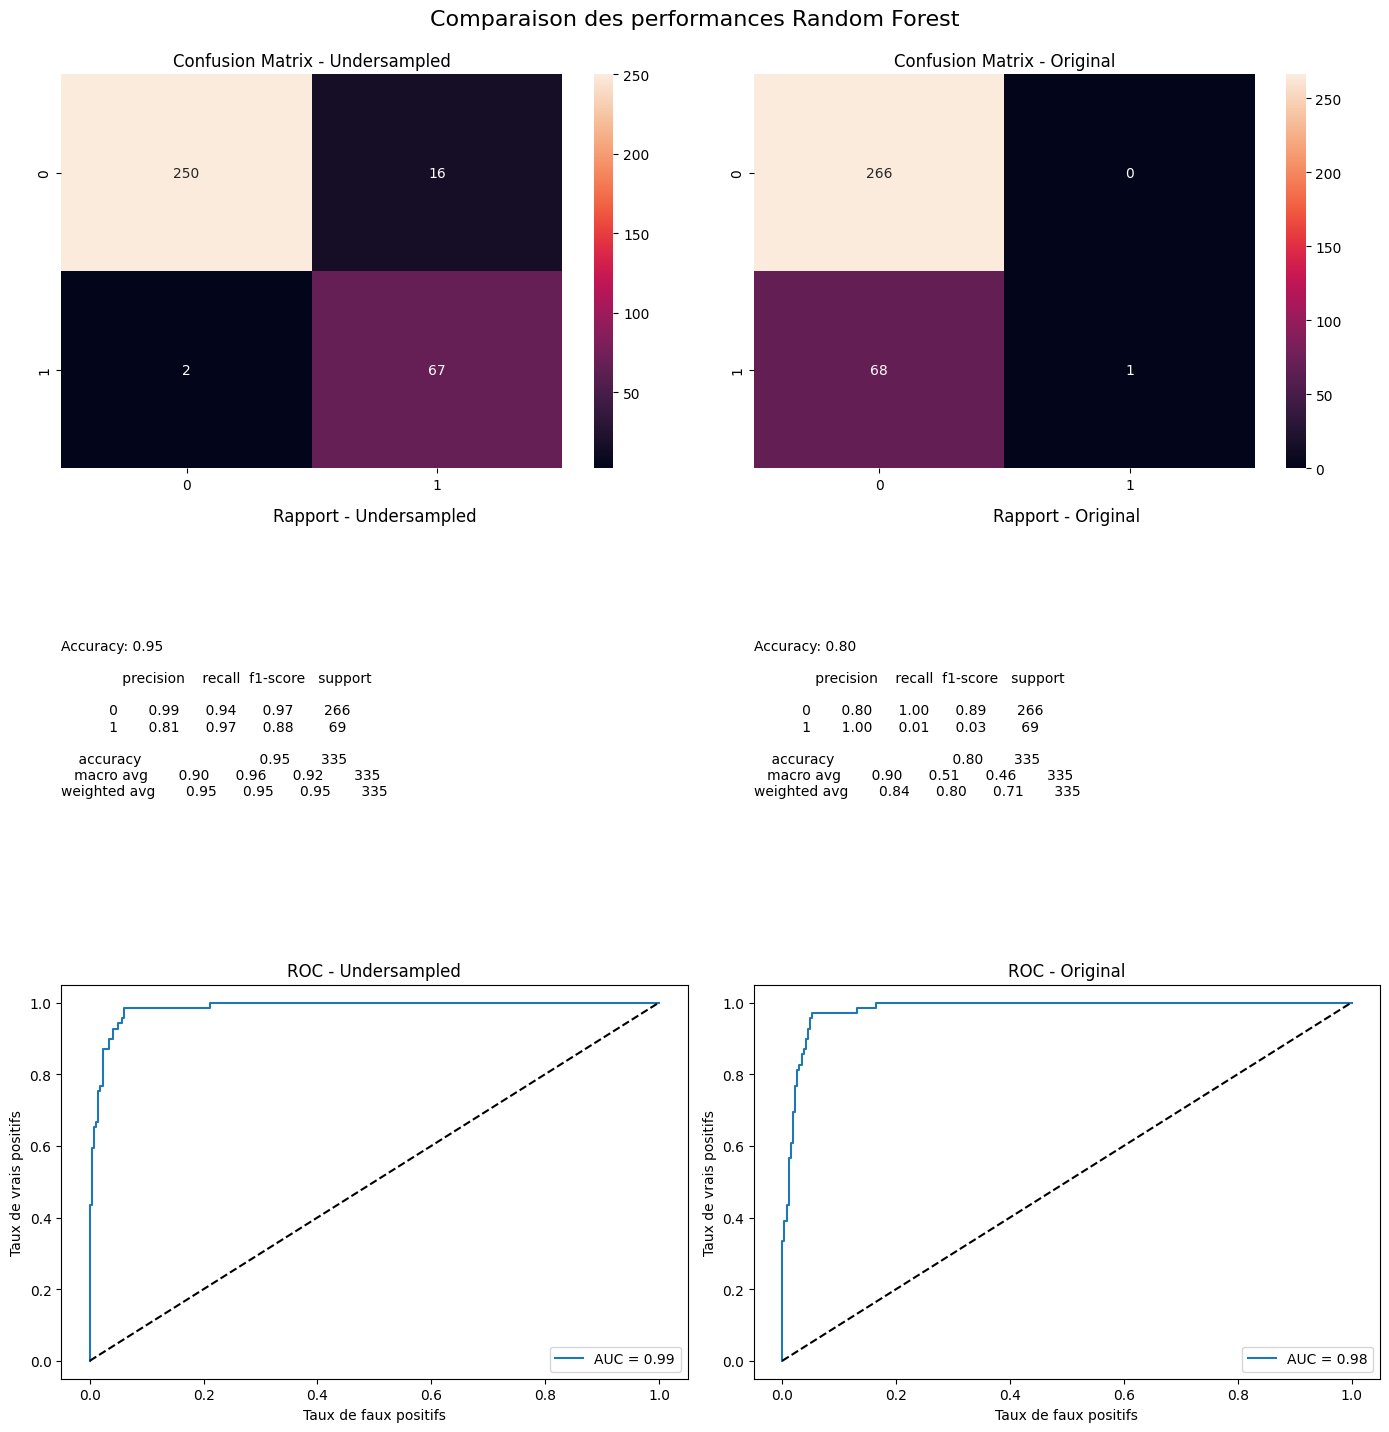

Méthode d'under-sampling :  cnn


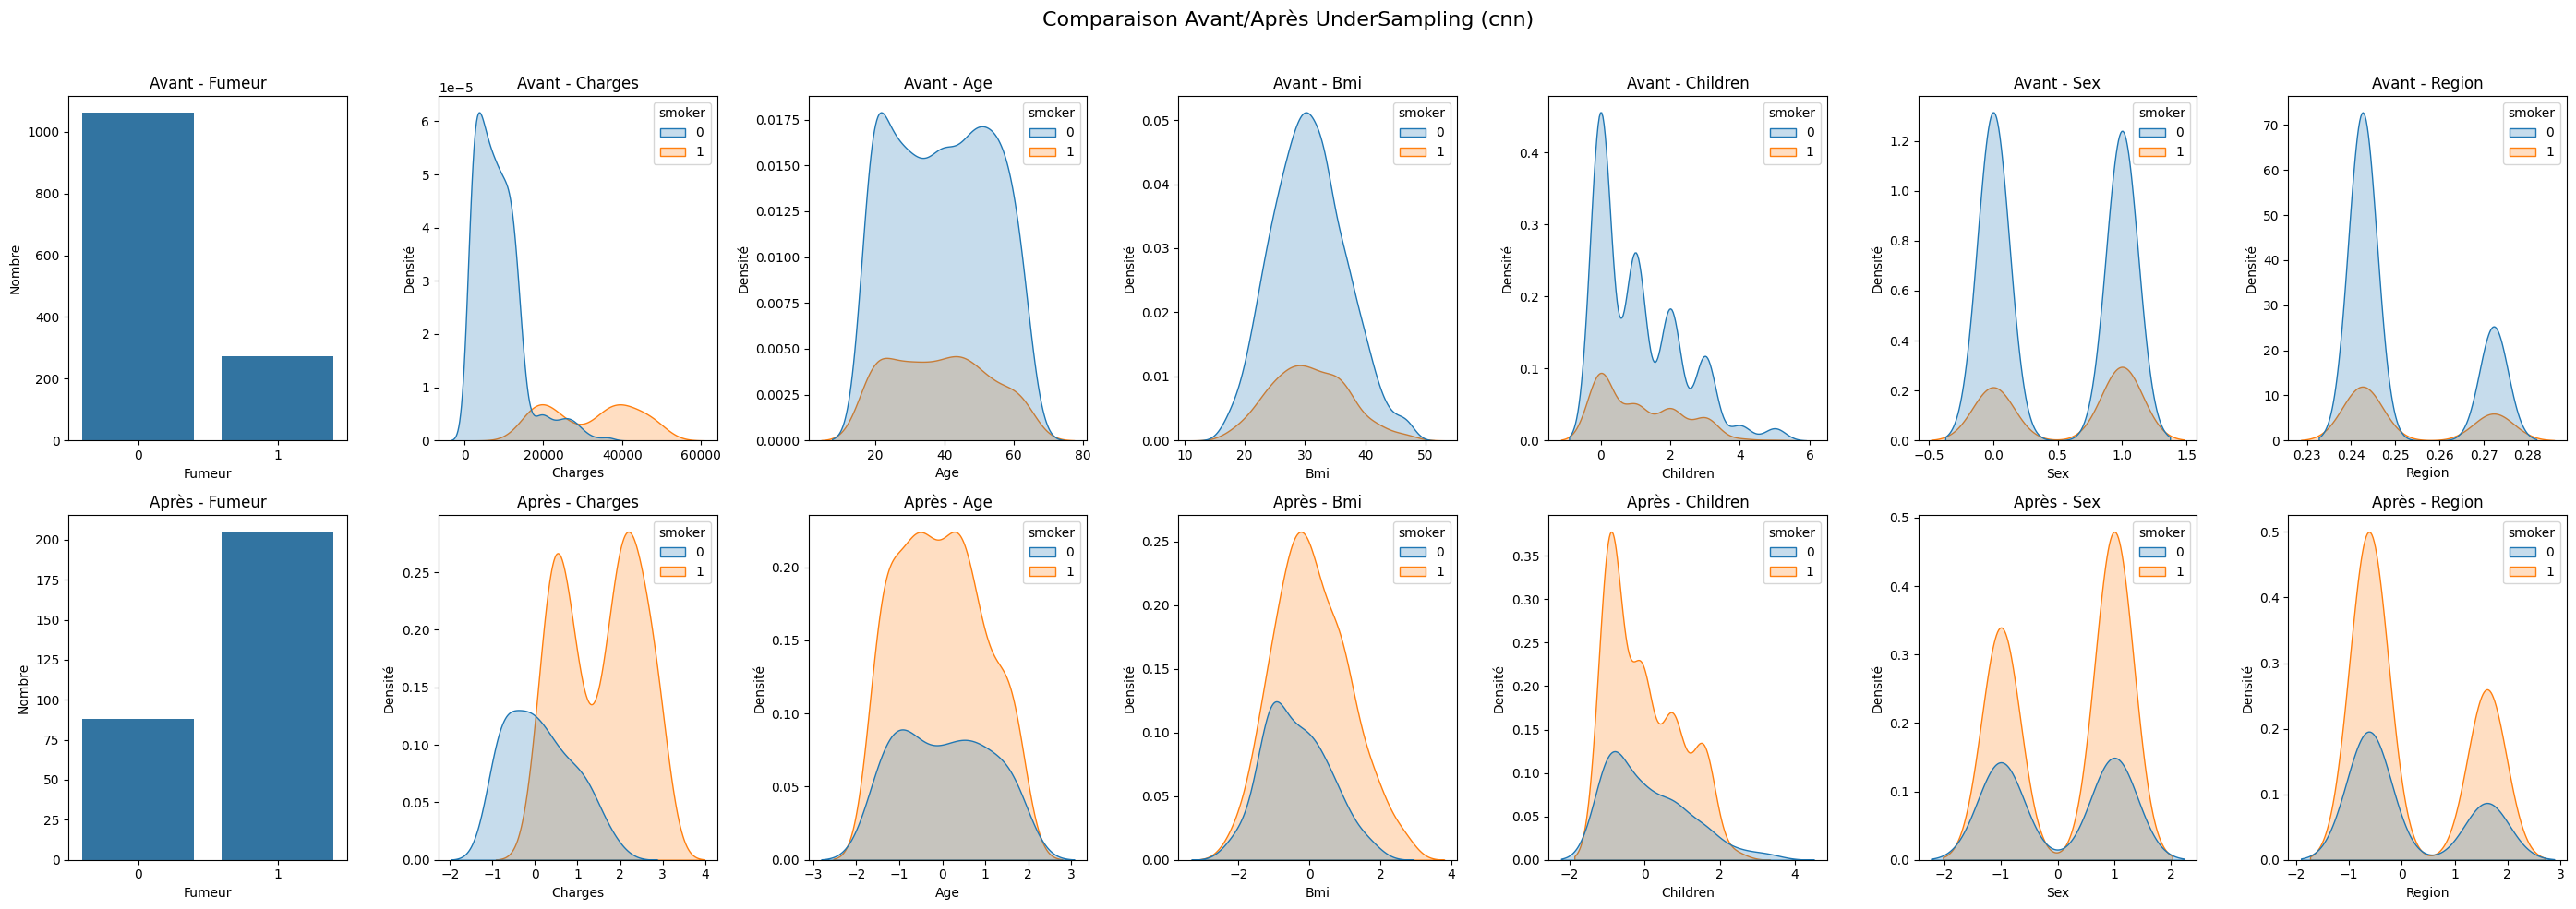

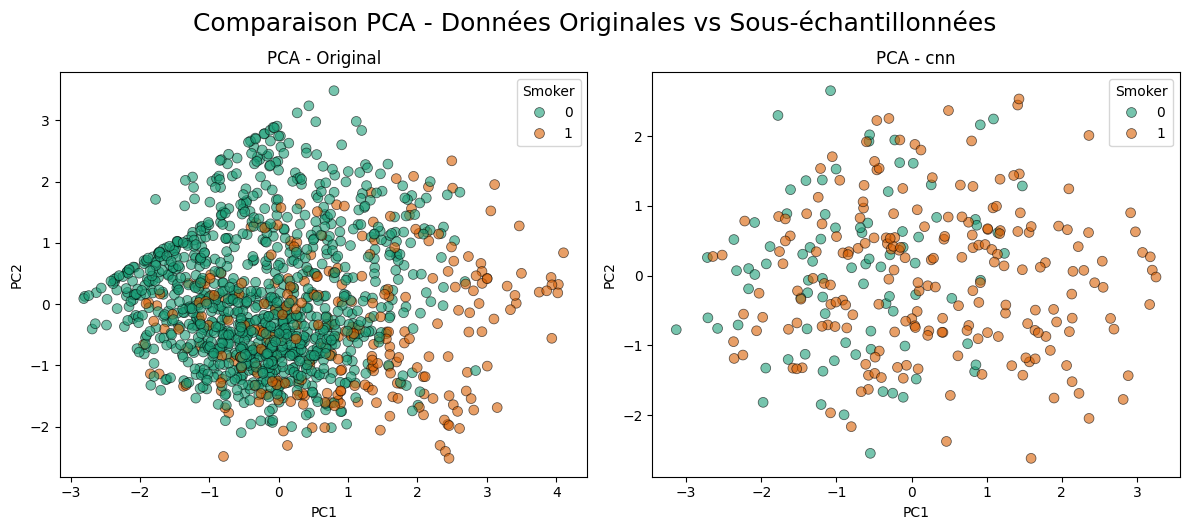


####### COMPARAISON PERFORMANCE - MÉTHODE : CNN #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.8600682593856656


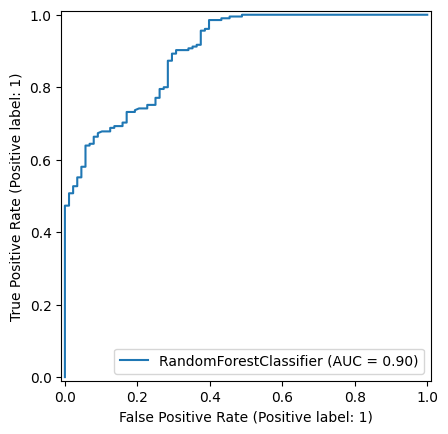

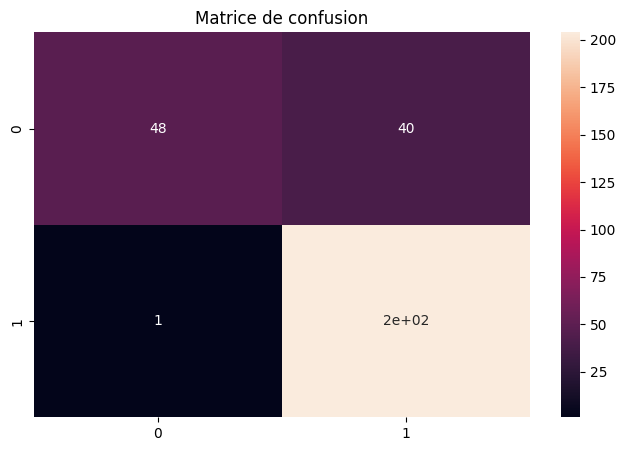

              precision    recall  f1-score   support

           0       0.98      0.55      0.70        88
           1       0.84      1.00      0.91       205

    accuracy                           0.86       293
   macro avg       0.91      0.77      0.80       293
weighted avg       0.88      0.86      0.85       293


=== Entraînement sur données originales ===
Accuracy :  0.8922155688622755


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


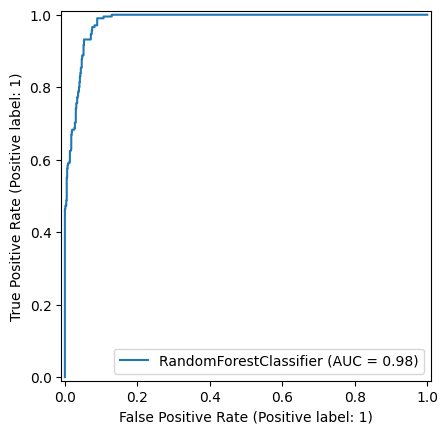

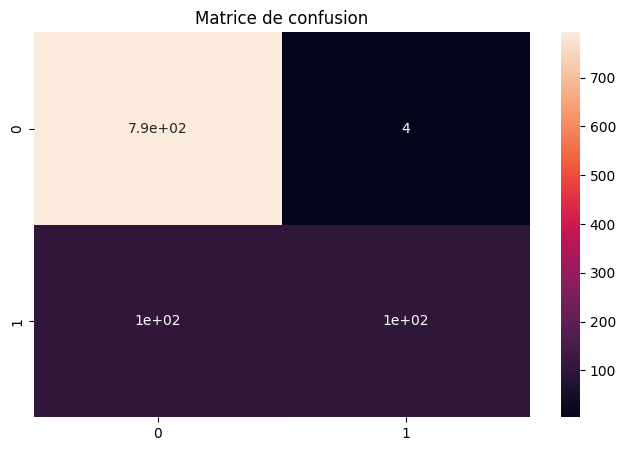

              precision    recall  f1-score   support

           0       0.88      0.99      0.94       797
           1       0.96      0.49      0.65       205

    accuracy                           0.89      1002
   macro avg       0.92      0.74      0.79      1002
weighted avg       0.90      0.89      0.88      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


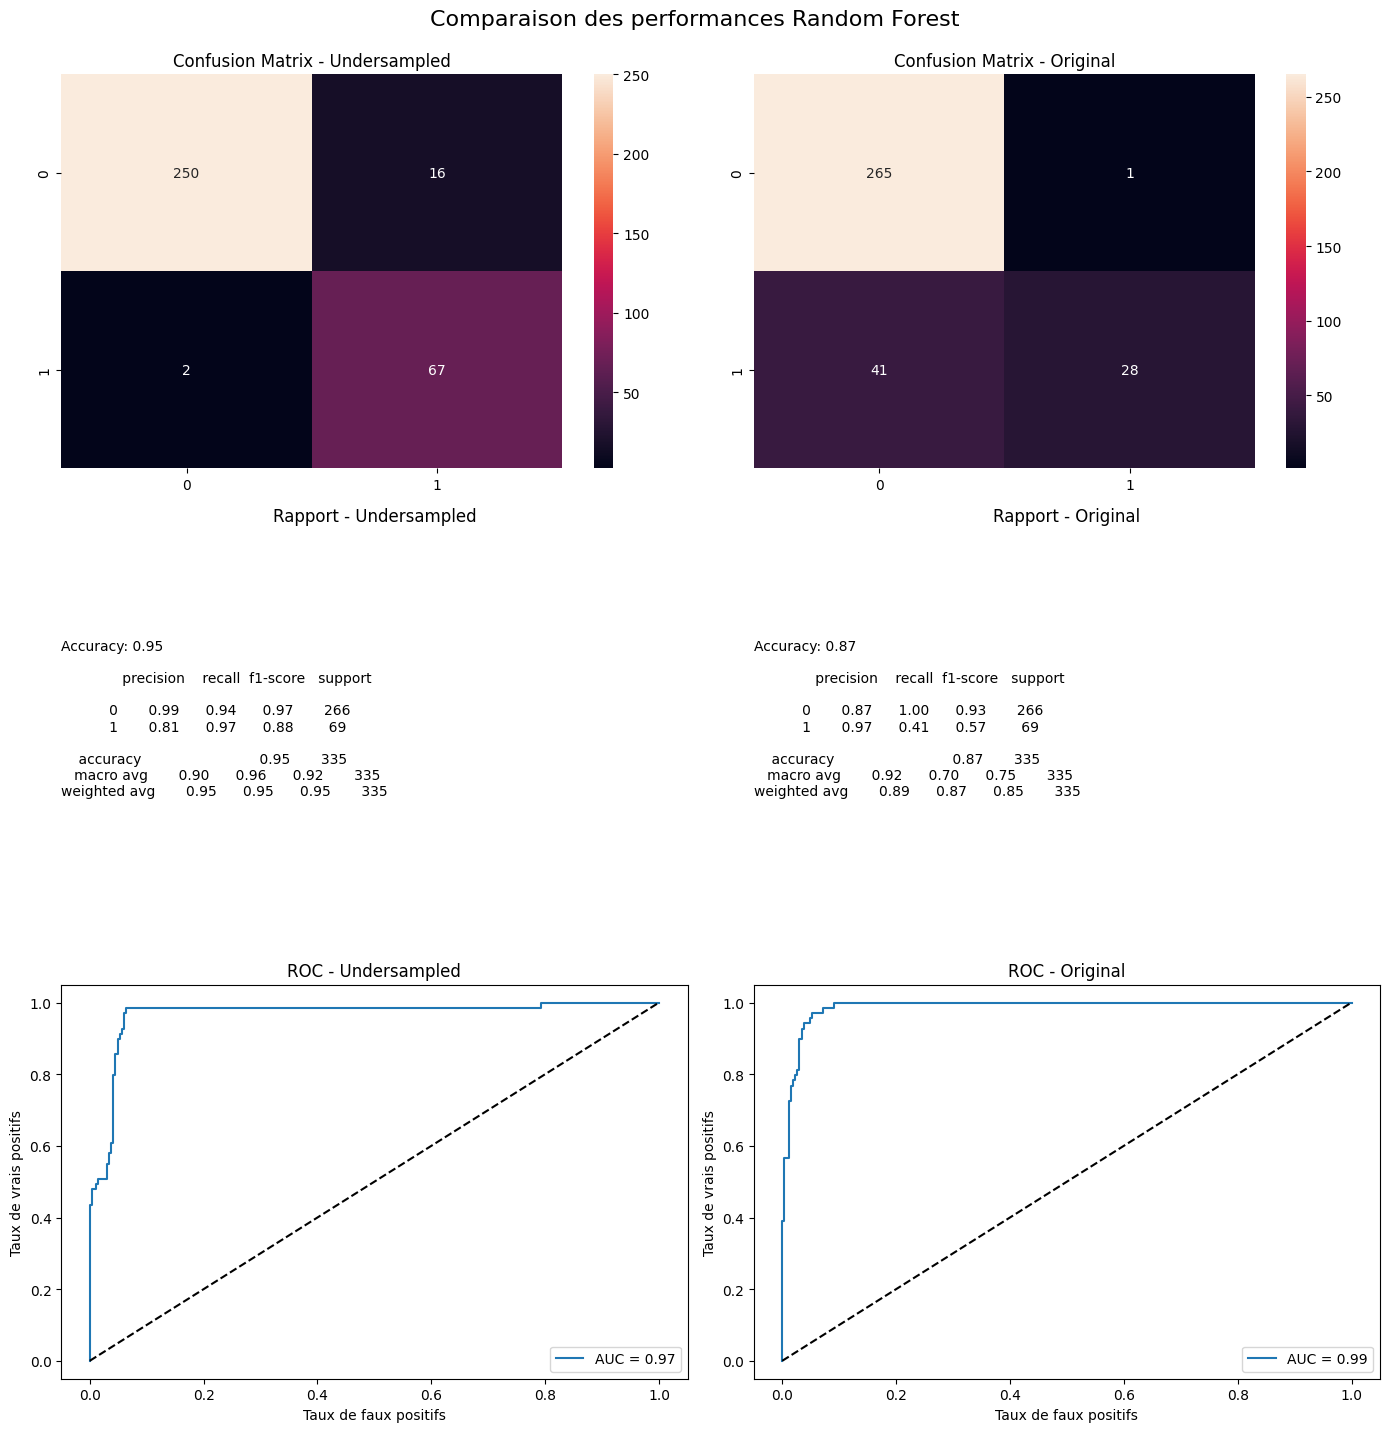

Méthode d'under-sampling :  tl


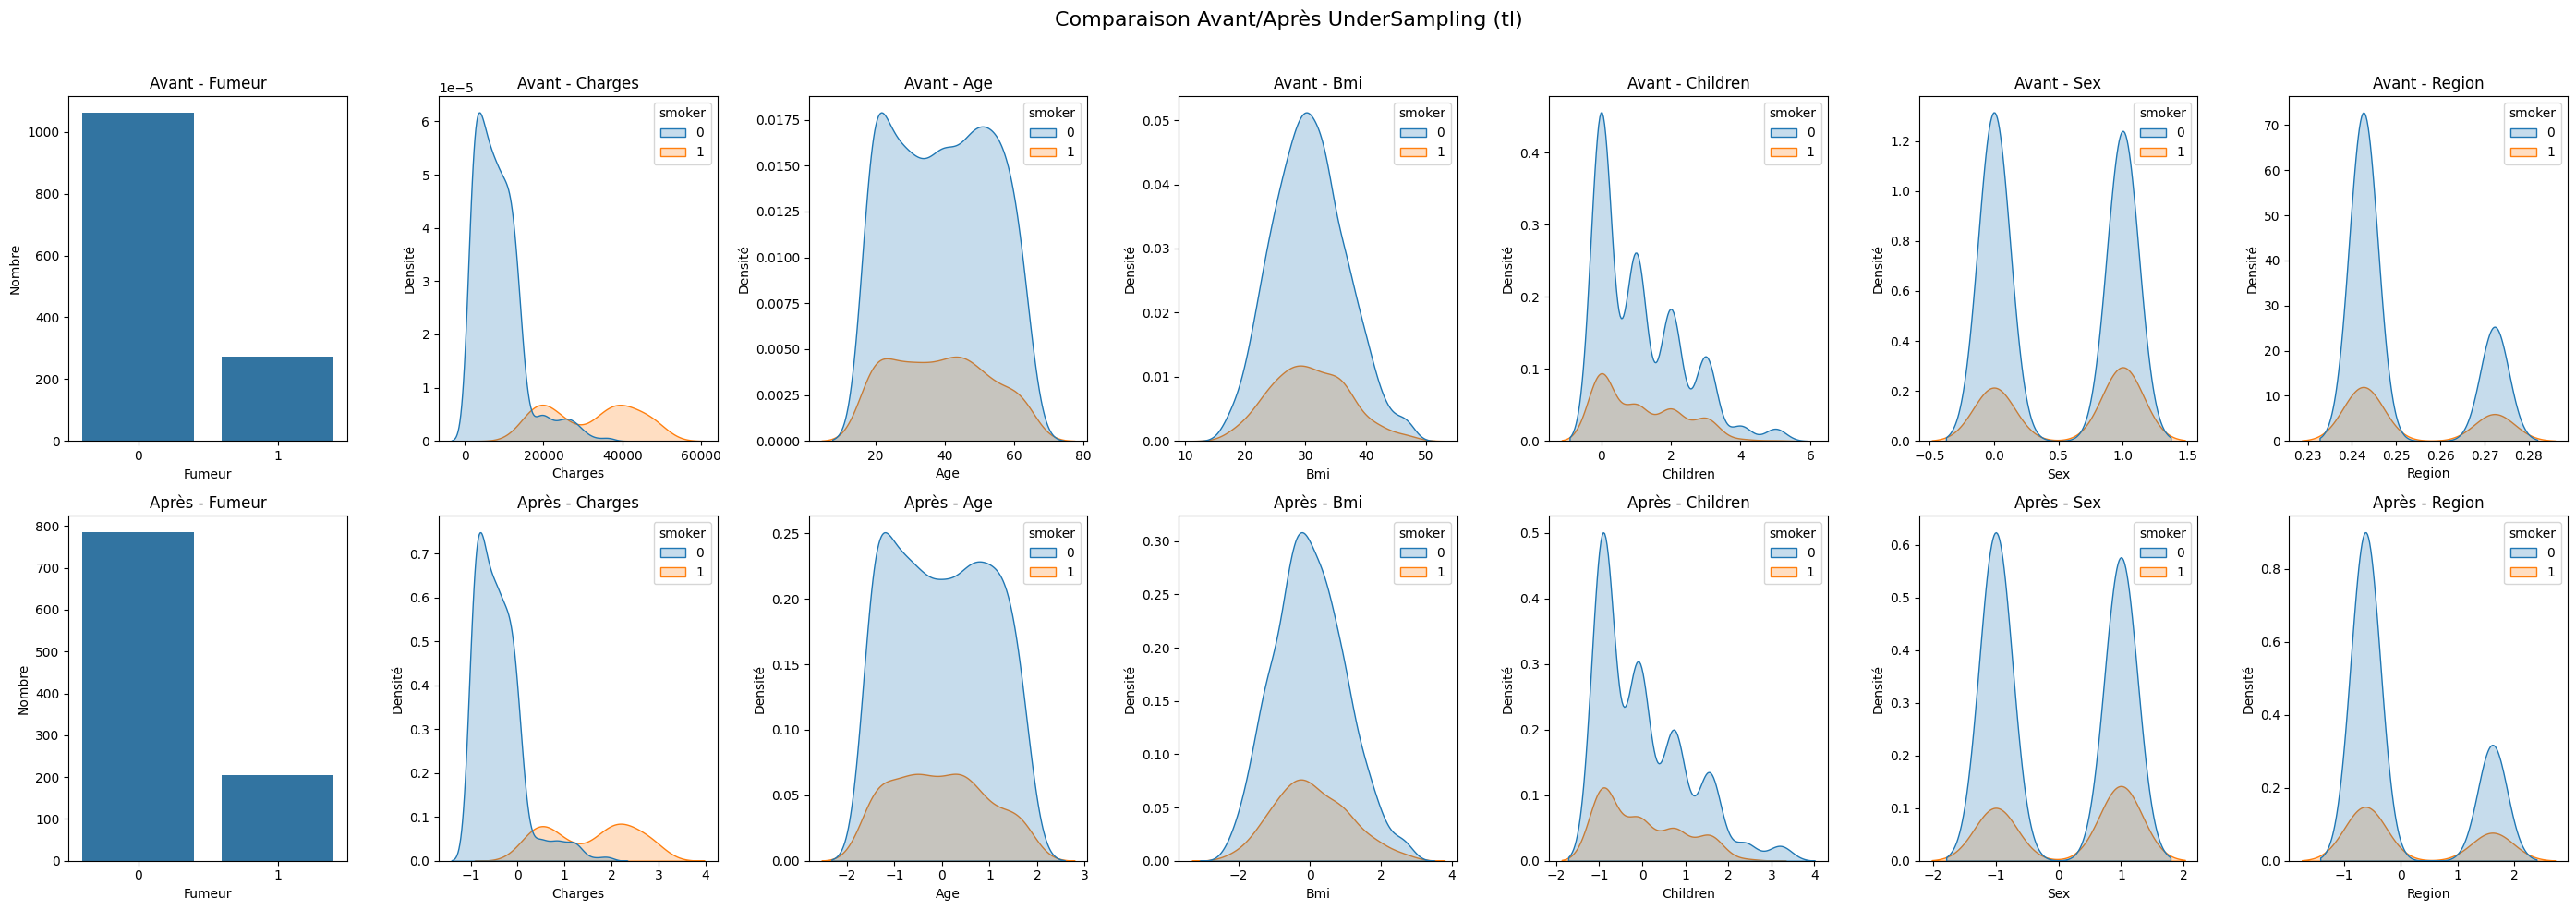

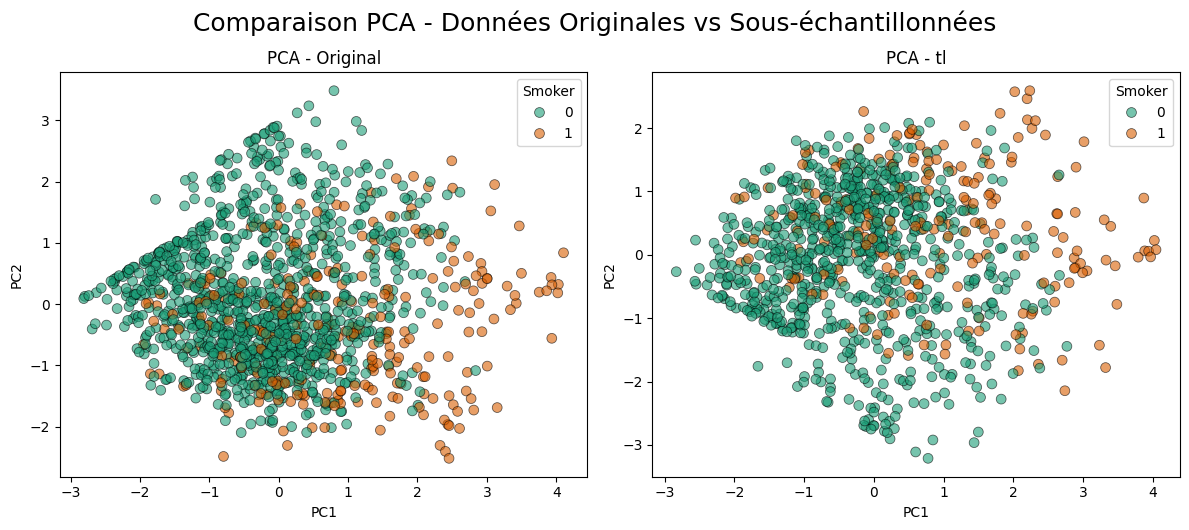


####### COMPARAISON PERFORMANCE - MÉTHODE : TL #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.9414141414141414


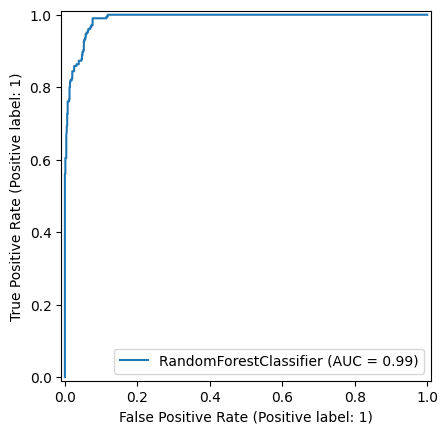

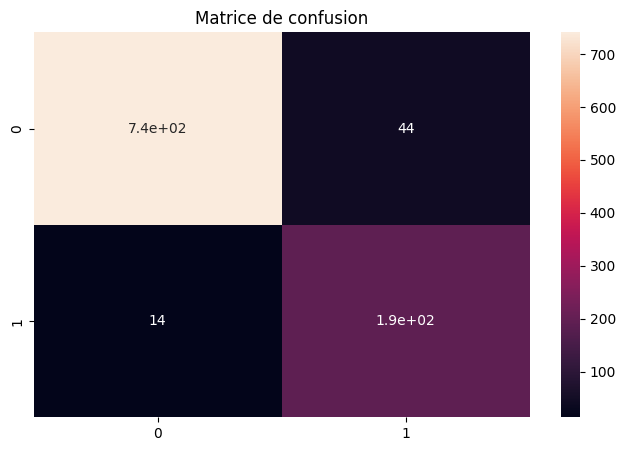

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       785
           1       0.81      0.93      0.87       205

    accuracy                           0.94       990
   macro avg       0.90      0.94      0.92       990
weighted avg       0.95      0.94      0.94       990


=== Entraînement sur données originales ===
Accuracy :  0.9011976047904192


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


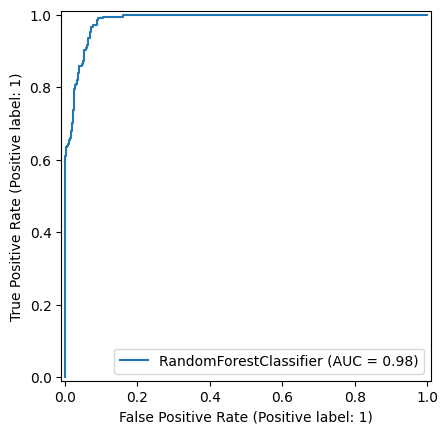

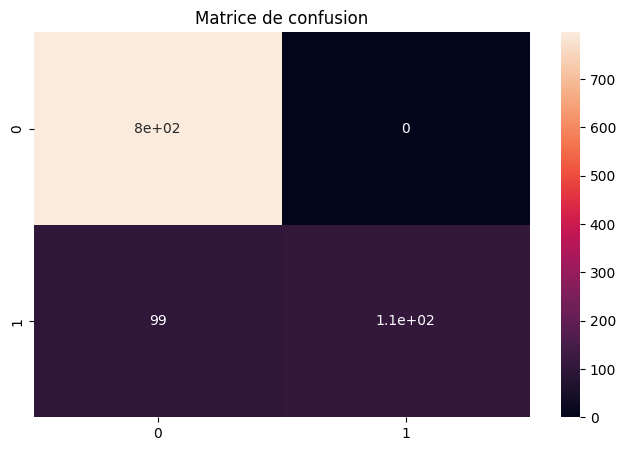

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       797
           1       1.00      0.52      0.68       205

    accuracy                           0.90      1002
   macro avg       0.94      0.76      0.81      1002
weighted avg       0.91      0.90      0.89      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


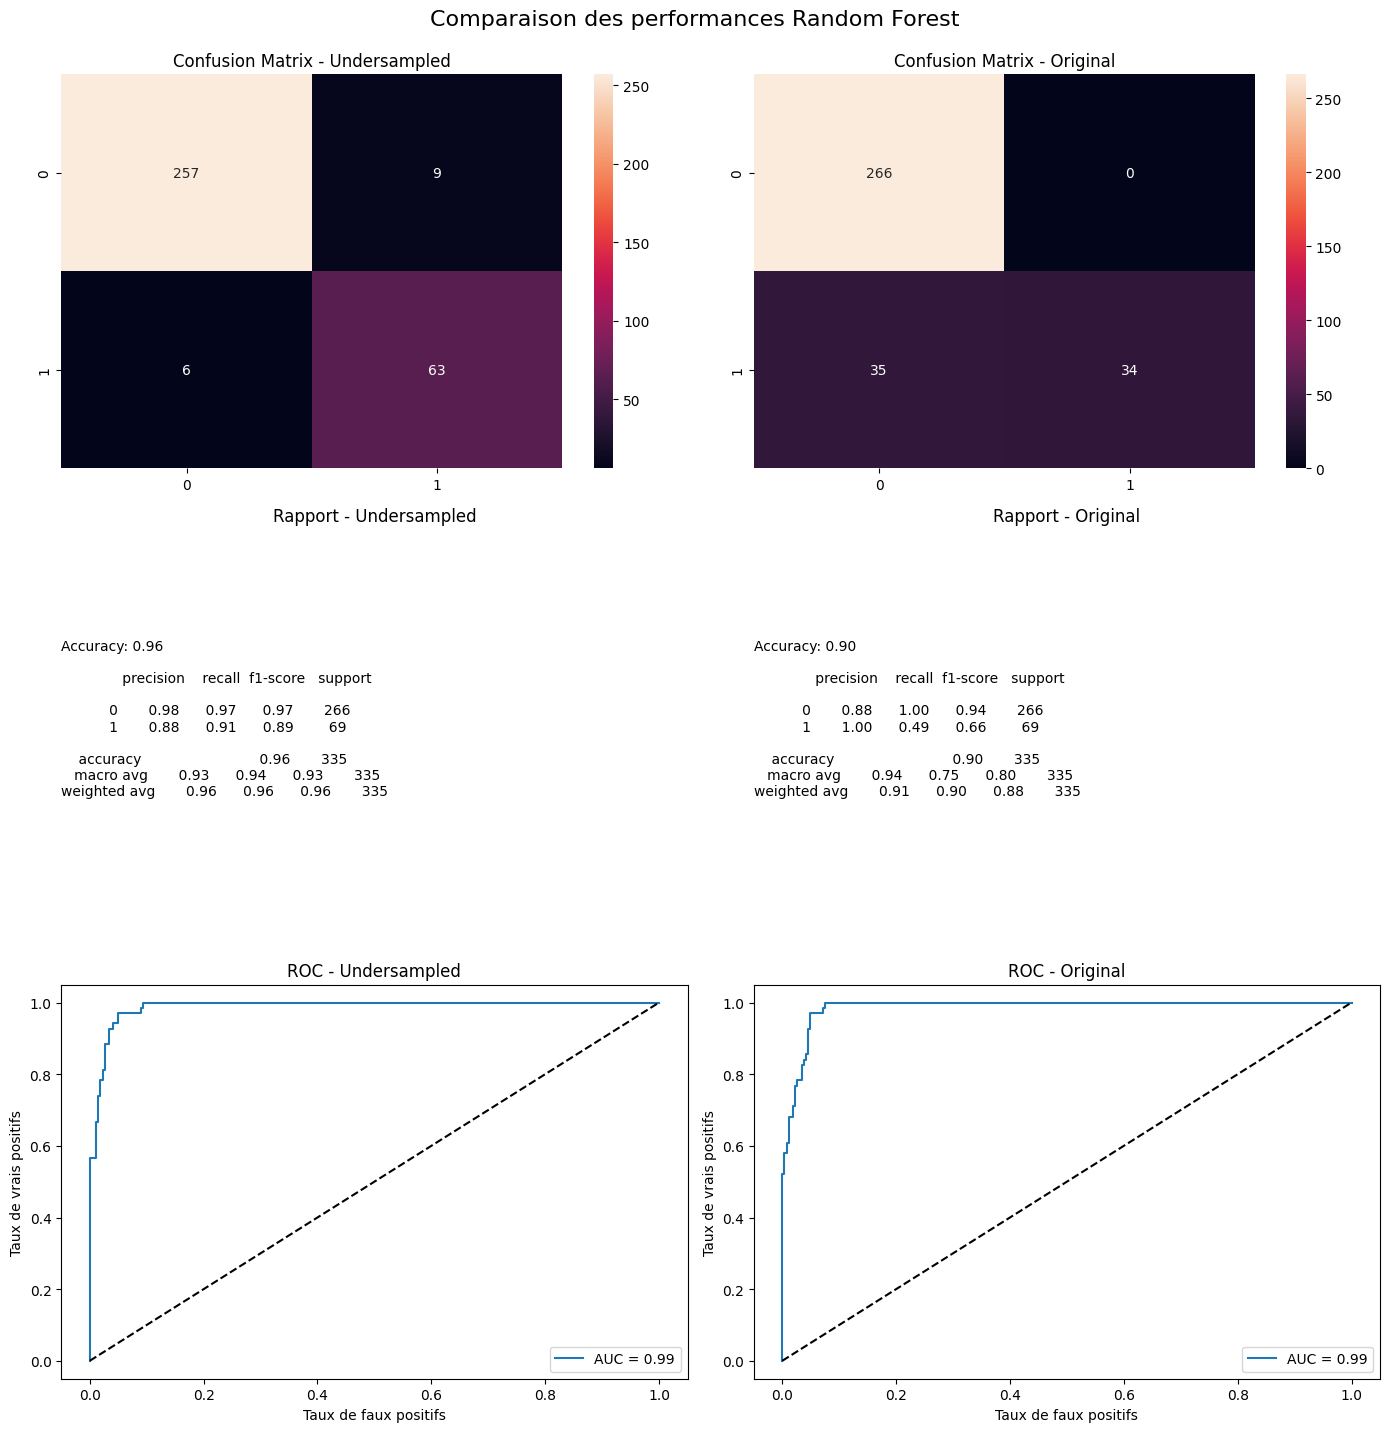

In [13]:
resampled_data_dict = {}

for undersampler in undersampler_dict.keys():
    print("Méthode d'under-sampling : ", undersampler)
    
    # Resampling des données
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)

    # Conversion en DataFrame si nécessaire
    if not isinstance(X_resampled, pd.DataFrame):
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    if isinstance(y_resampled, pd.DataFrame):
        y_resampled = y_resampled.iloc[:, 0]
    else:
        y_resampled = pd.Series(y_resampled, name='smoker')
    
    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Sauvegarde pour éventuelle réutilisation
    resampled_data_dict[undersampler] = data_resampled
    
    # Visualisation comparative
    compare_smoker_distribution(data, data_resampled, title_suffix=f"({undersampler})")
    compare_pca_oversampling(data, {undersampler: data_resampled})

    # Comparaison de performance tout de suite après la visualisation
    print(f"\n####### COMPARAISON PERFORMANCE - MÉTHODE : {undersampler.upper()} #######")
    X_train_resampled = data_resampled.drop(columns='smoker')
    y_train_resampled = data_resampled['smoker']

    compare_random_forest_performance(
        X_train_orig=X_train, y_train_orig=y_train,
        X_train_res=X_train_resampled, y_train_res=y_train_resampled,
        X_test=X_test, y_test=y_test
    )

## Naives bayes
### requilibrage et control de l'impact sur le modeles 

Méthode d'under-sampling :  random


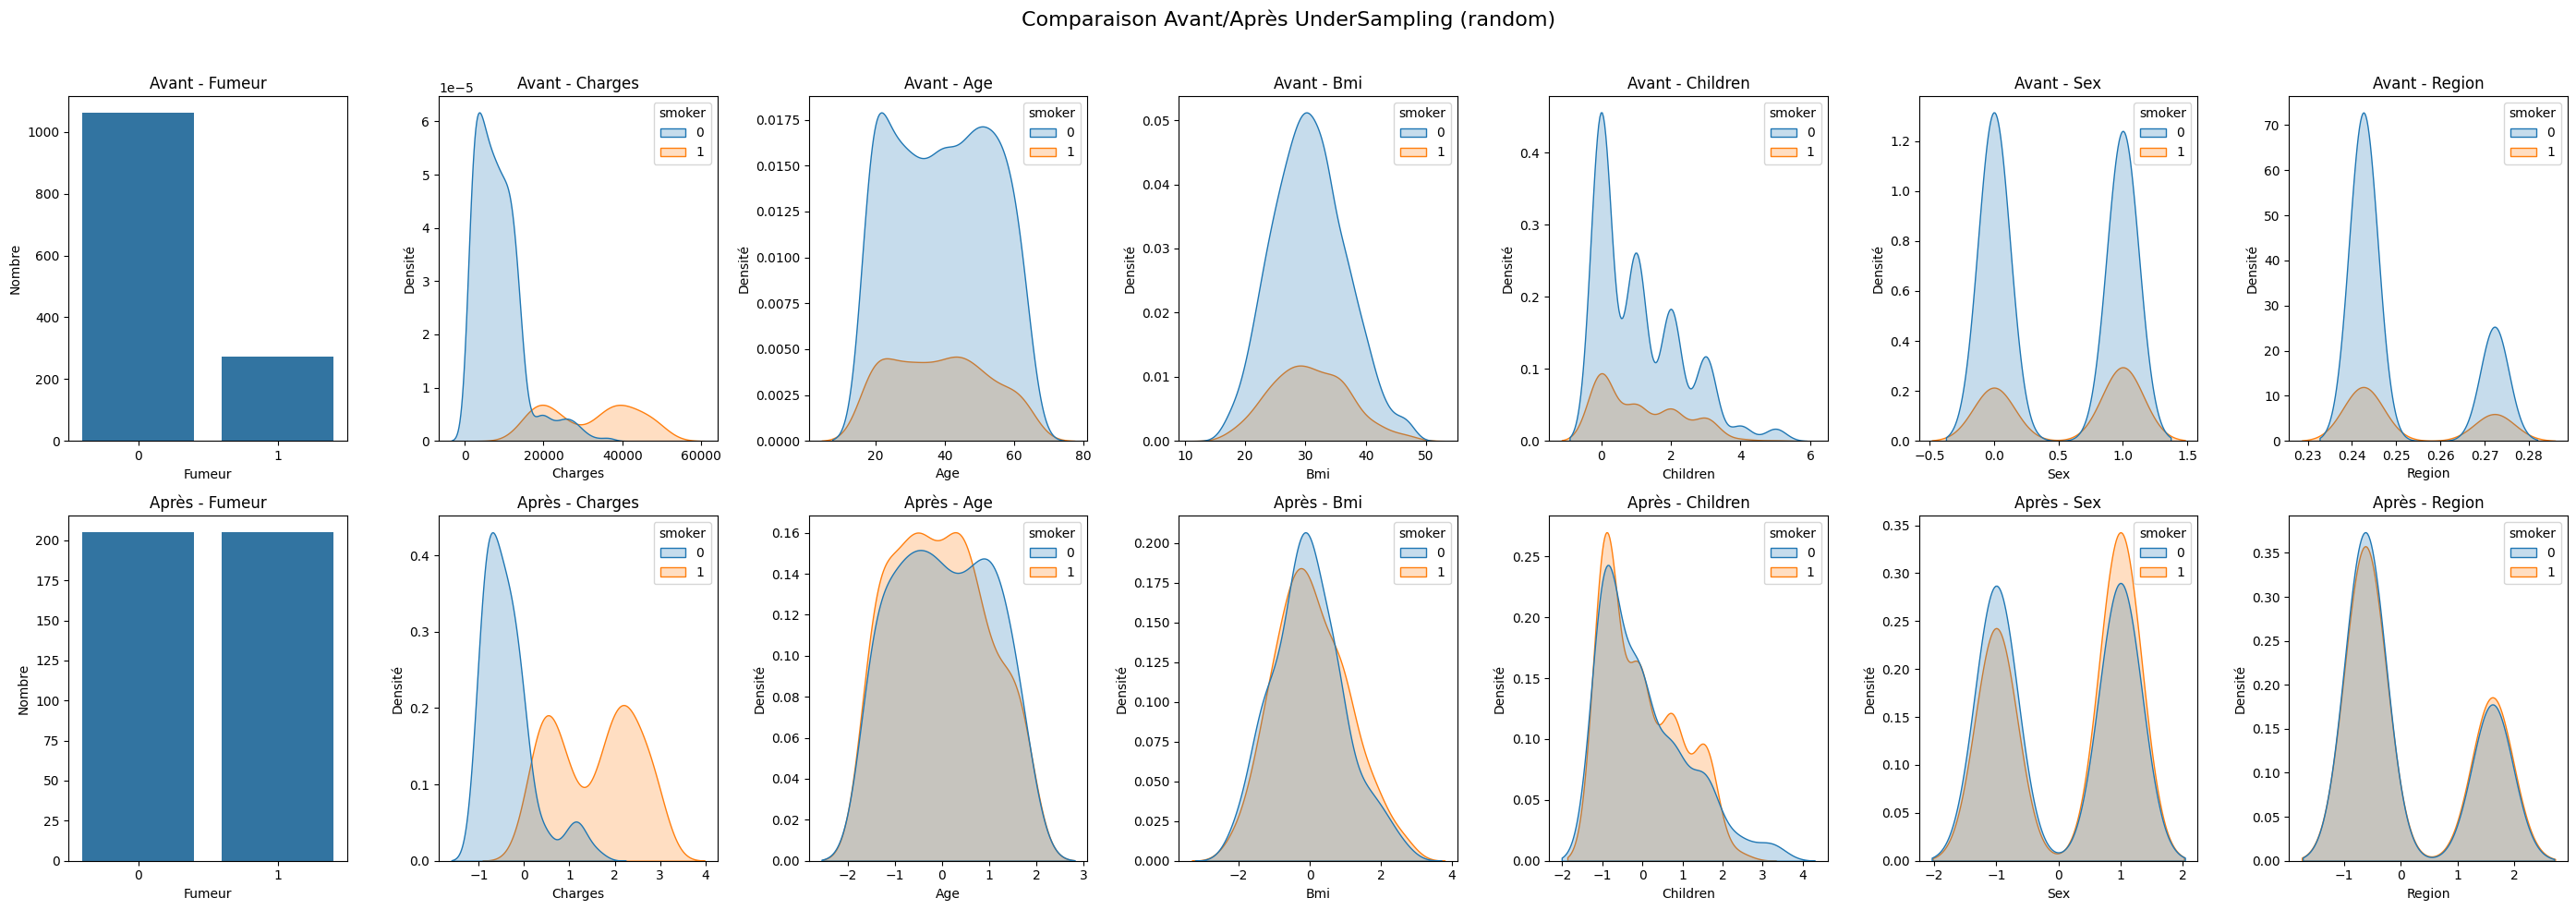

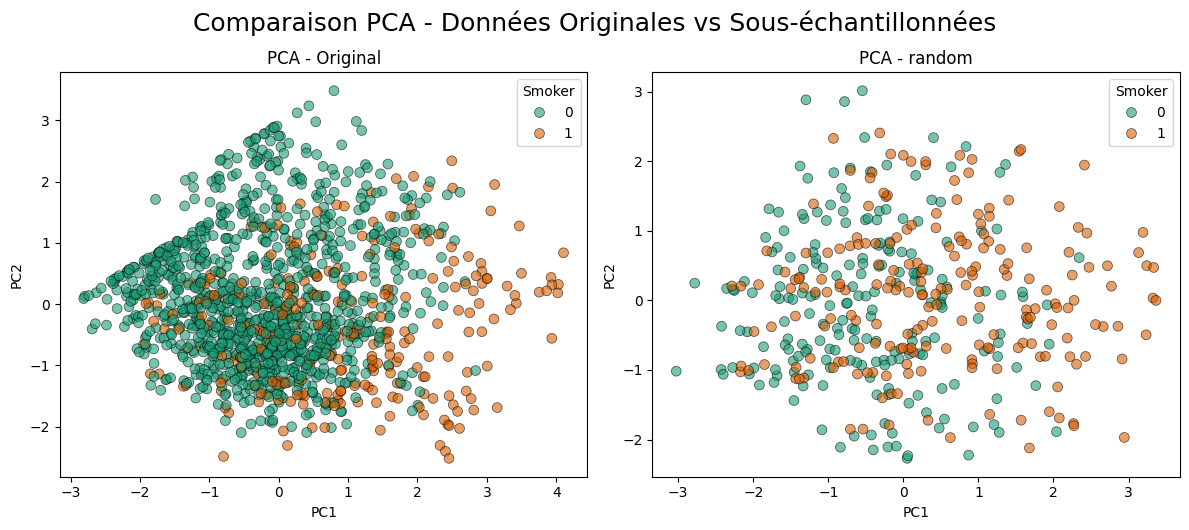


####### COMPARAISON PERFORMANCE - MÉTHODE : RANDOM #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.8658536585365854


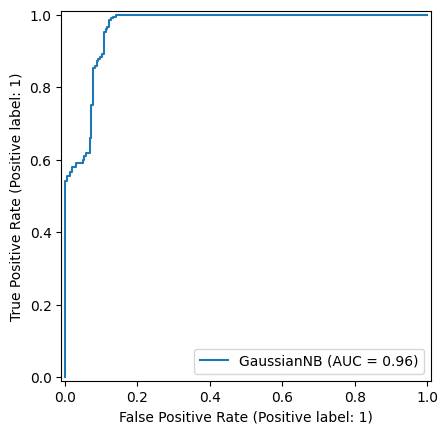

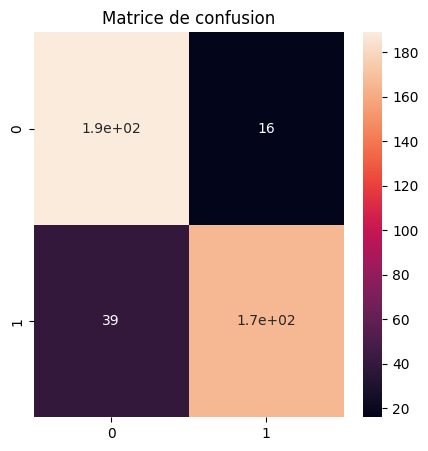

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       205
           1       0.91      0.81      0.86       205

    accuracy                           0.87       410
   macro avg       0.87      0.87      0.87       410
weighted avg       0.87      0.87      0.87       410


=== Entraînement sur données originales ===
Accuracy :  0.8972055888223552


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


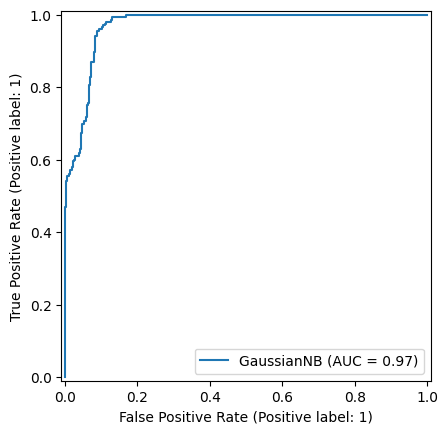

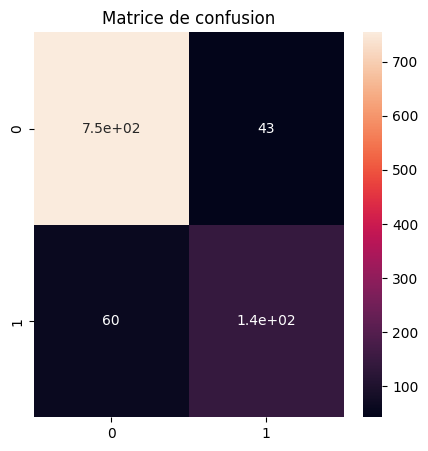

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       797
           1       0.77      0.71      0.74       205

    accuracy                           0.90      1002
   macro avg       0.85      0.83      0.84      1002
weighted avg       0.89      0.90      0.90      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


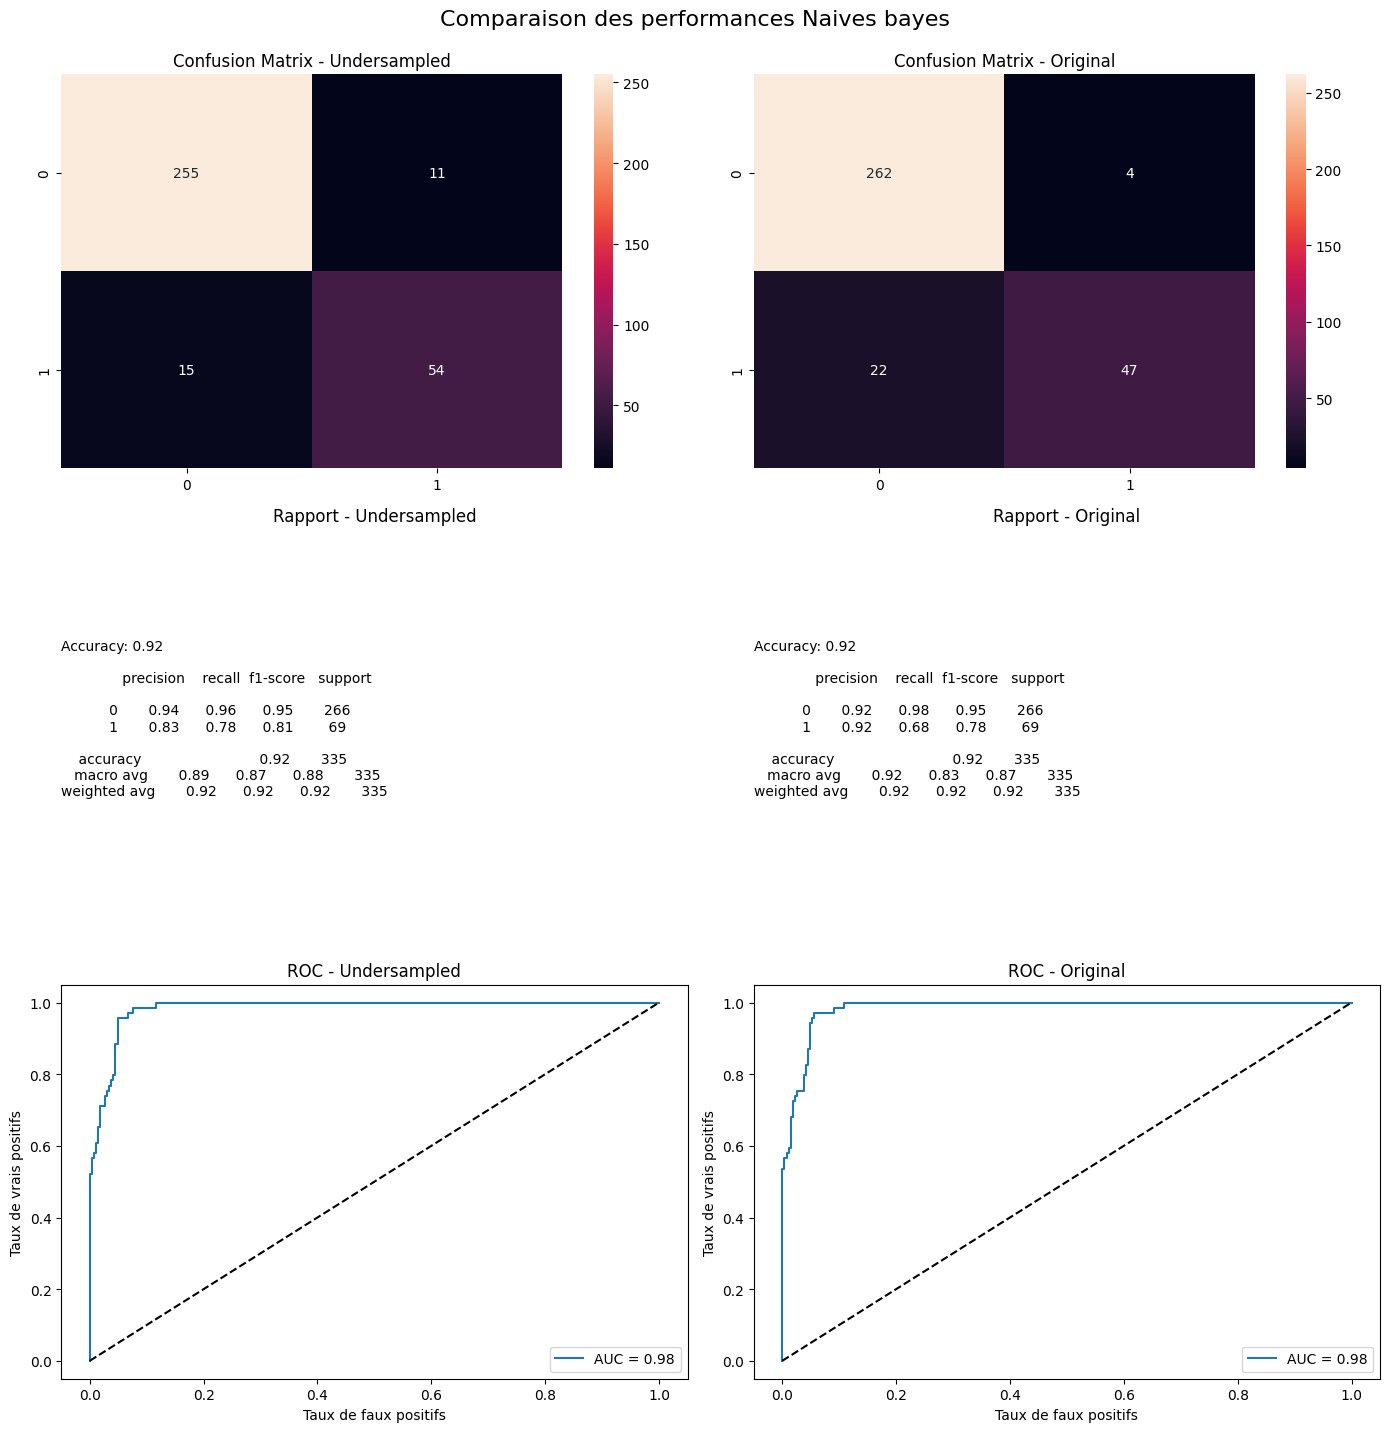

Méthode d'under-sampling :  cnn


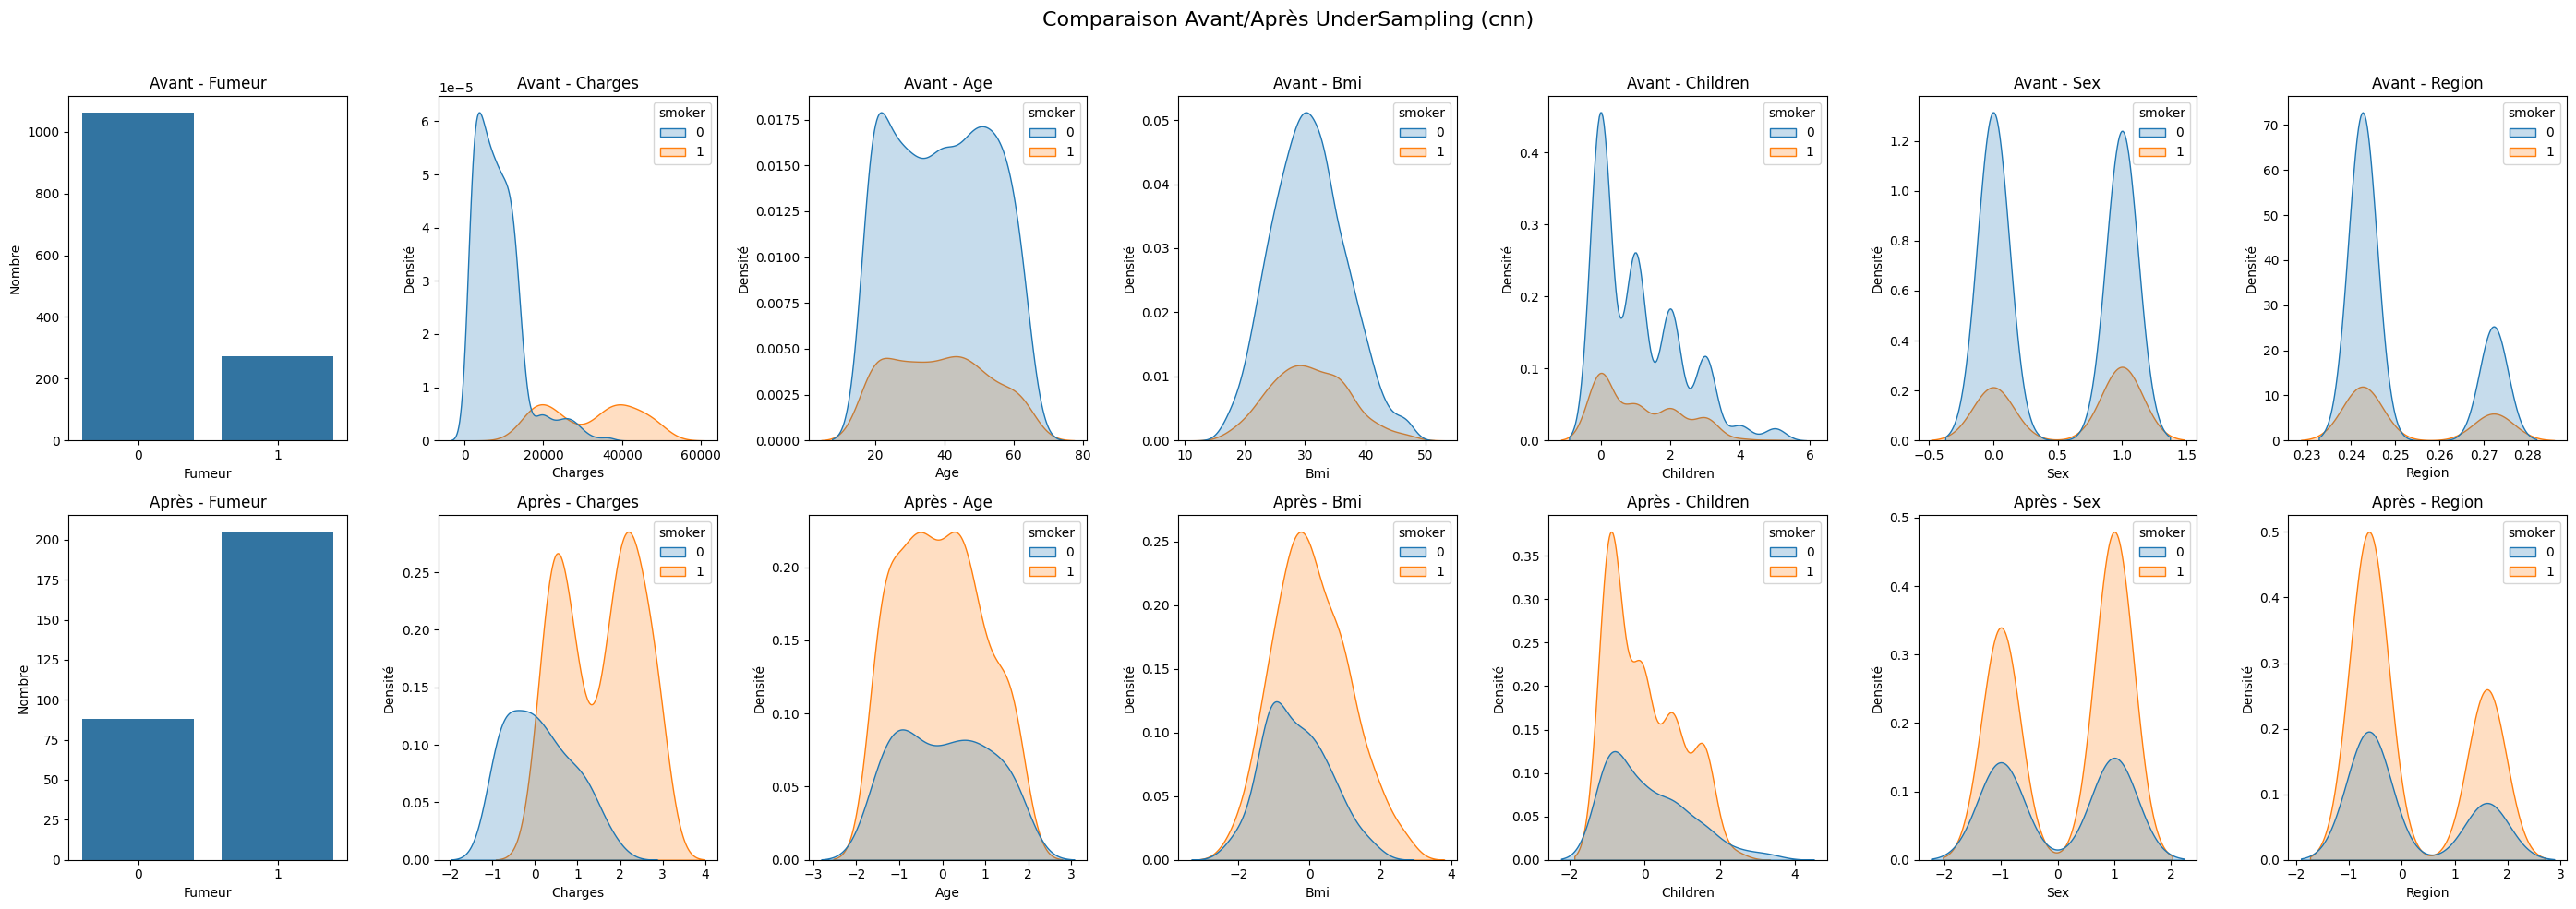

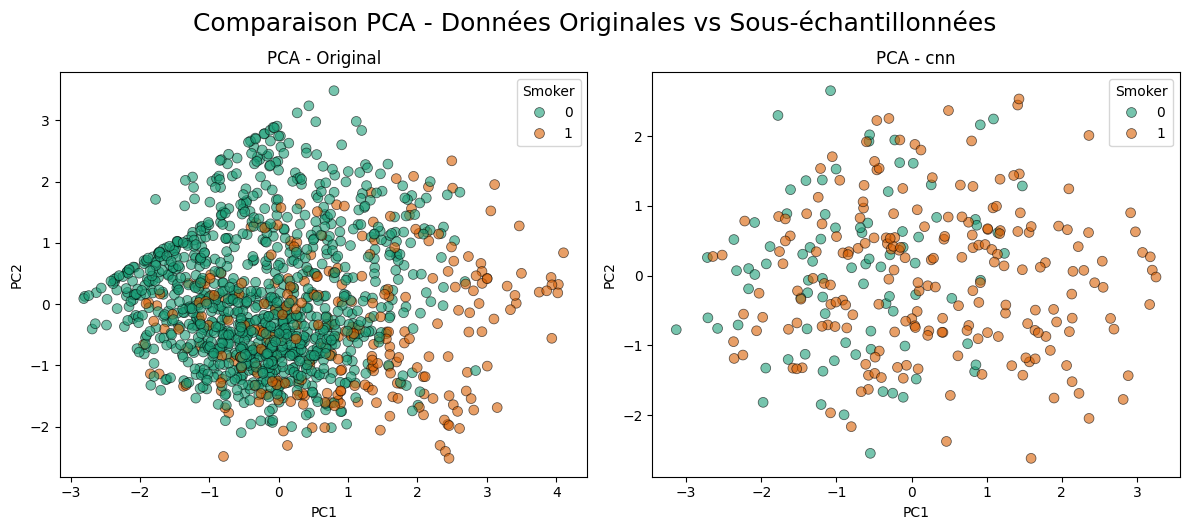


####### COMPARAISON PERFORMANCE - MÉTHODE : CNN #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.7372013651877133


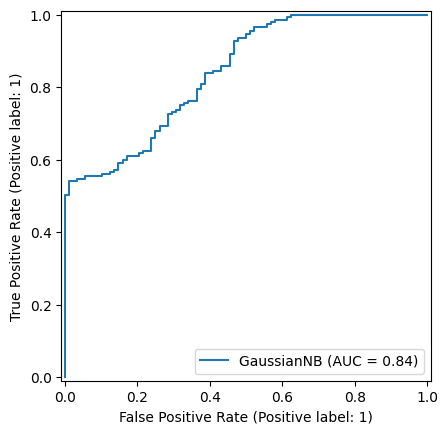

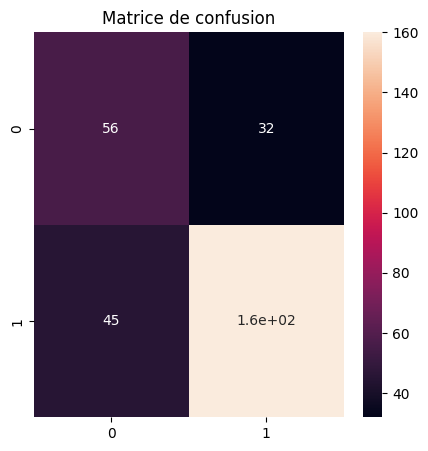

              precision    recall  f1-score   support

           0       0.55      0.64      0.59        88
           1       0.83      0.78      0.81       205

    accuracy                           0.74       293
   macro avg       0.69      0.71      0.70       293
weighted avg       0.75      0.74      0.74       293


=== Entraînement sur données originales ===
Accuracy :  0.8972055888223552


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


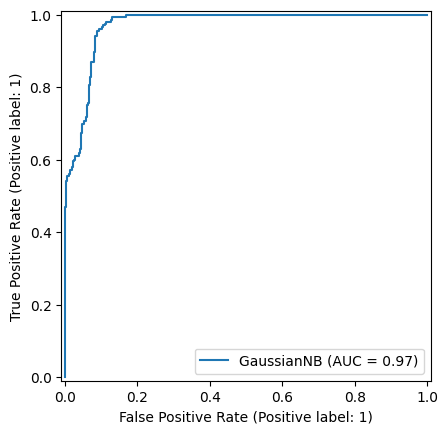

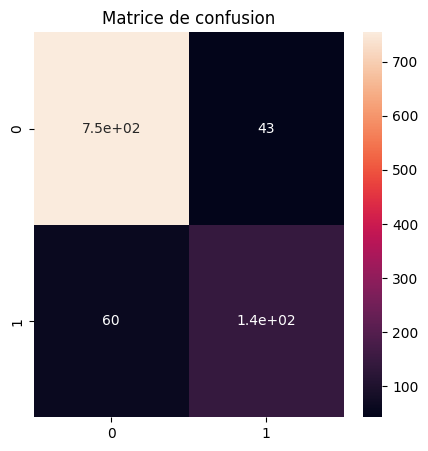

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       797
           1       0.77      0.71      0.74       205

    accuracy                           0.90      1002
   macro avg       0.85      0.83      0.84      1002
weighted avg       0.89      0.90      0.90      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


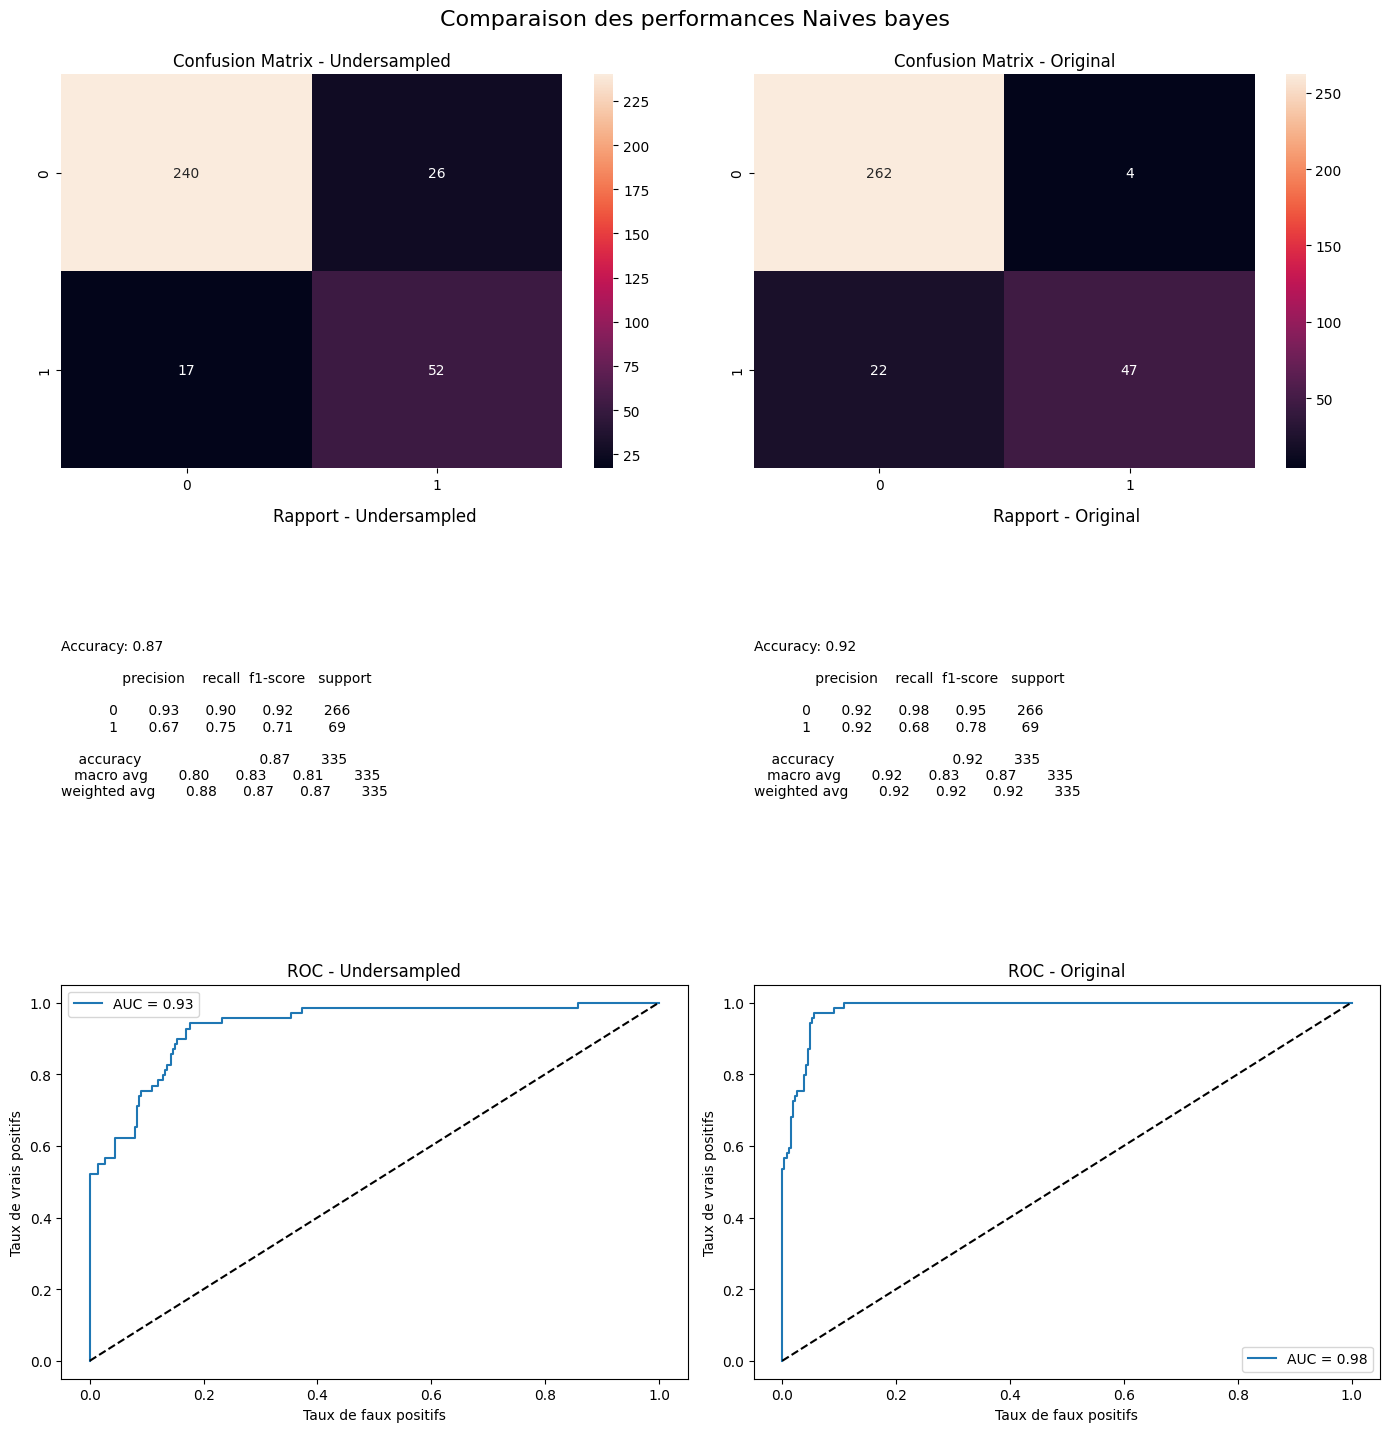

Méthode d'under-sampling :  tl


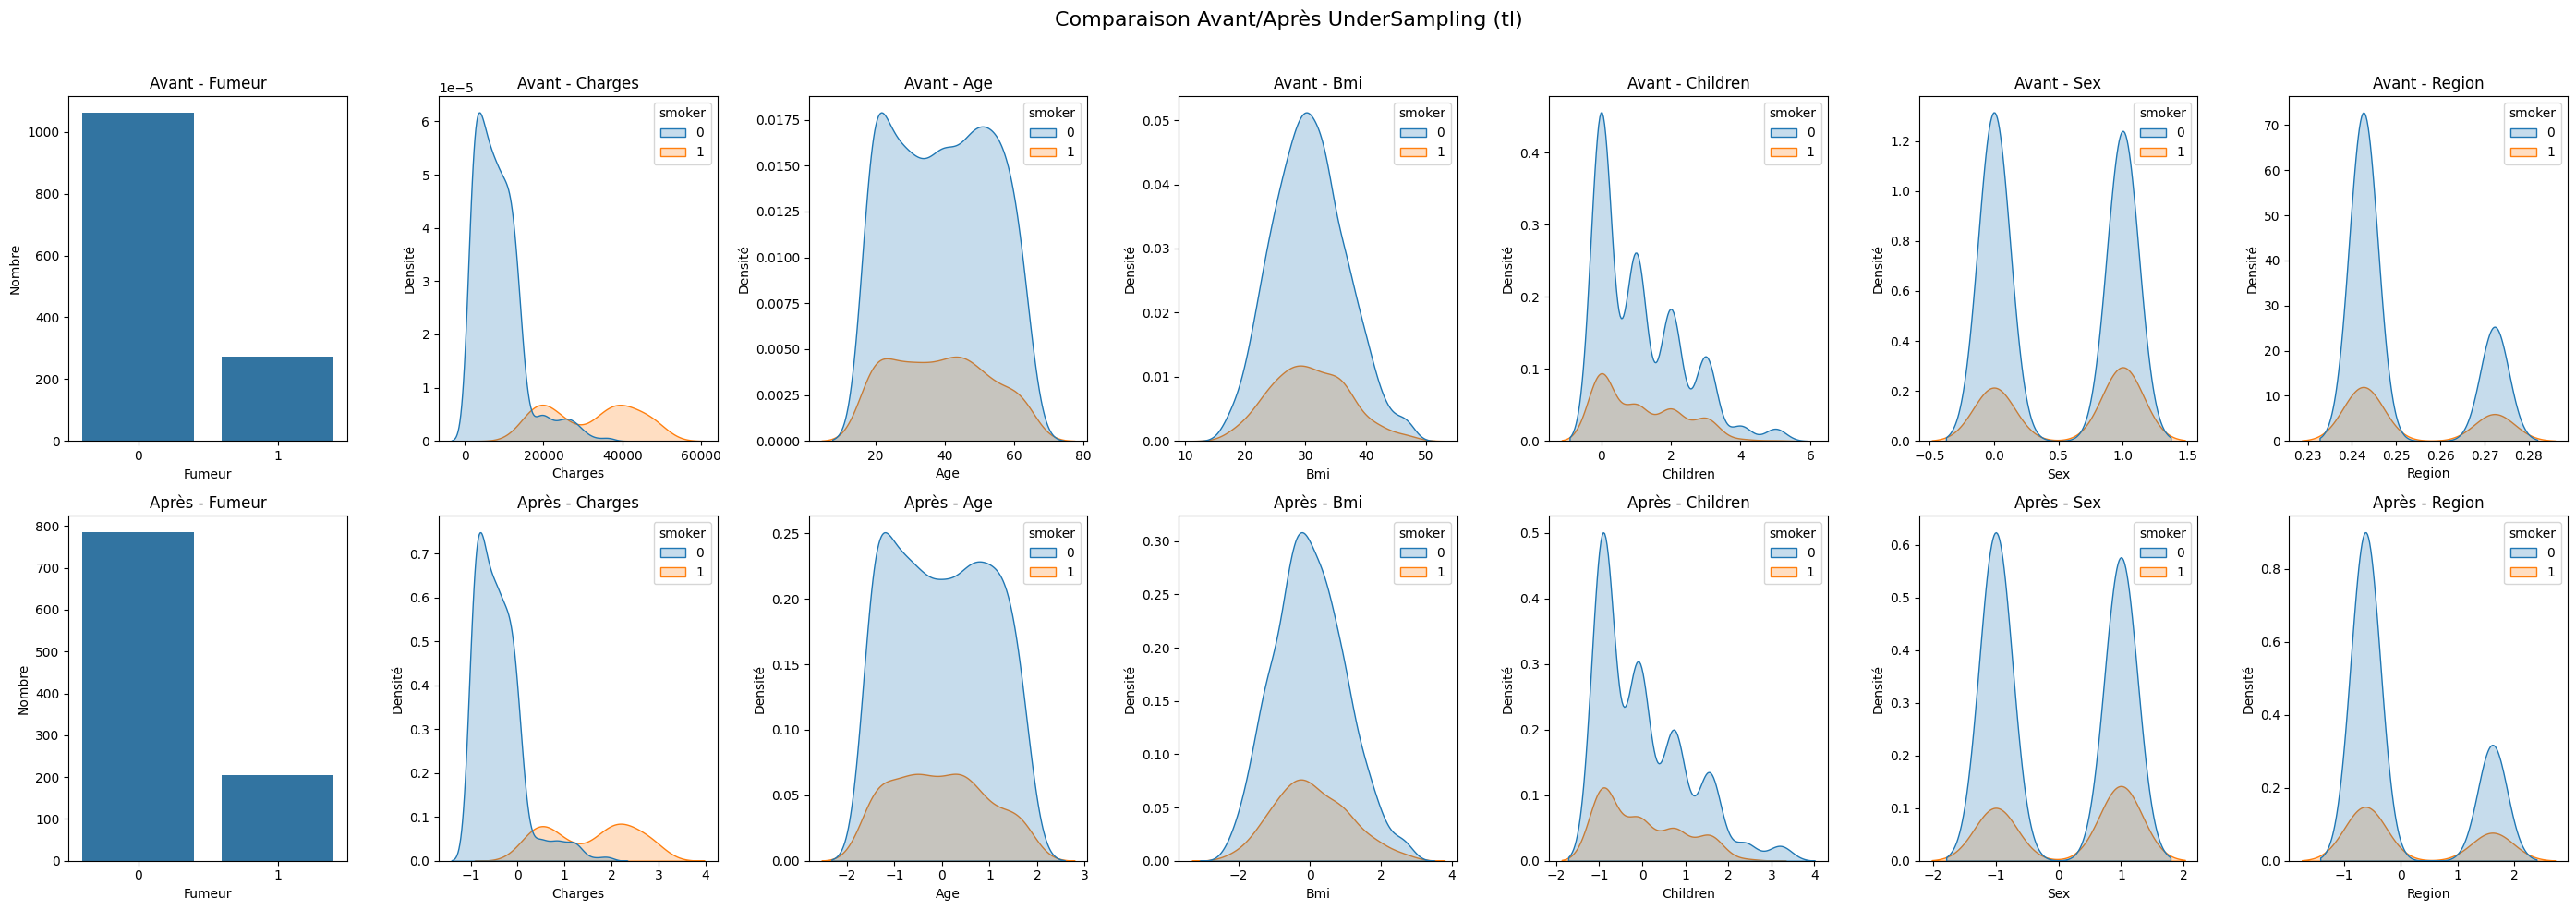

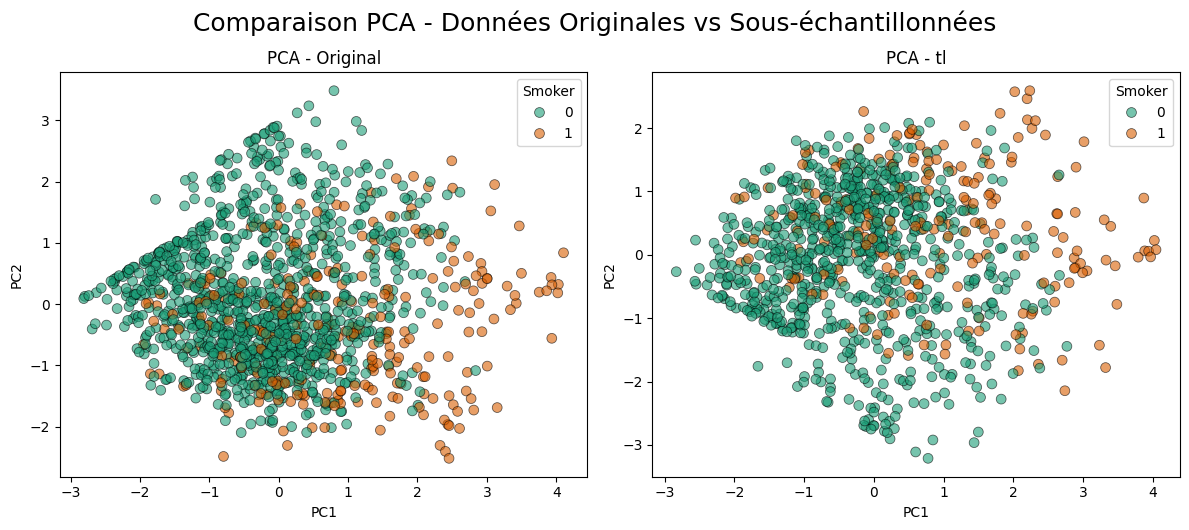


####### COMPARAISON PERFORMANCE - MÉTHODE : TL #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.901010101010101


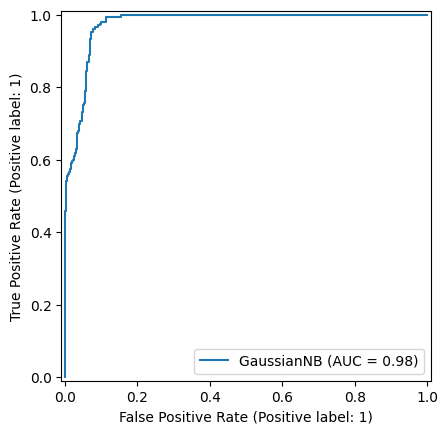

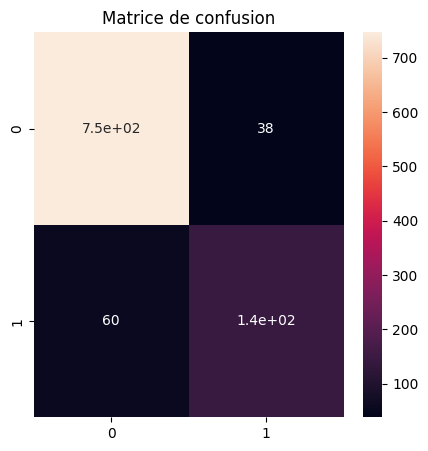

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       785
           1       0.79      0.71      0.75       205

    accuracy                           0.90       990
   macro avg       0.86      0.83      0.84       990
weighted avg       0.90      0.90      0.90       990


=== Entraînement sur données originales ===
Accuracy :  0.8972055888223552


/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


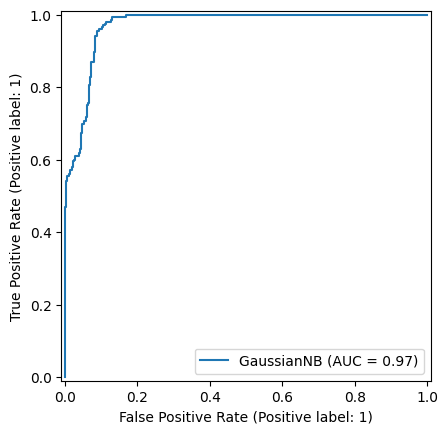

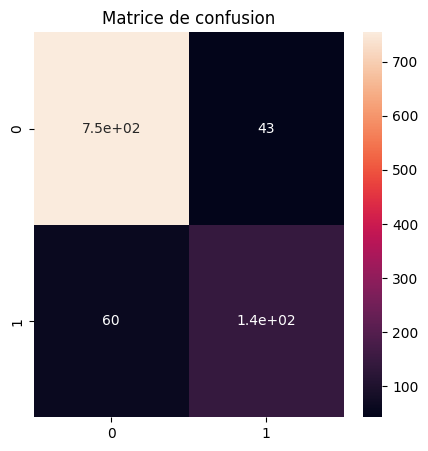

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       797
           1       0.77      0.71      0.74       205

    accuracy                           0.90      1002
   macro avg       0.85      0.83      0.84      1002
weighted avg       0.89      0.90      0.90      1002



/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/yann/.pyenv/versions/machineLearning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


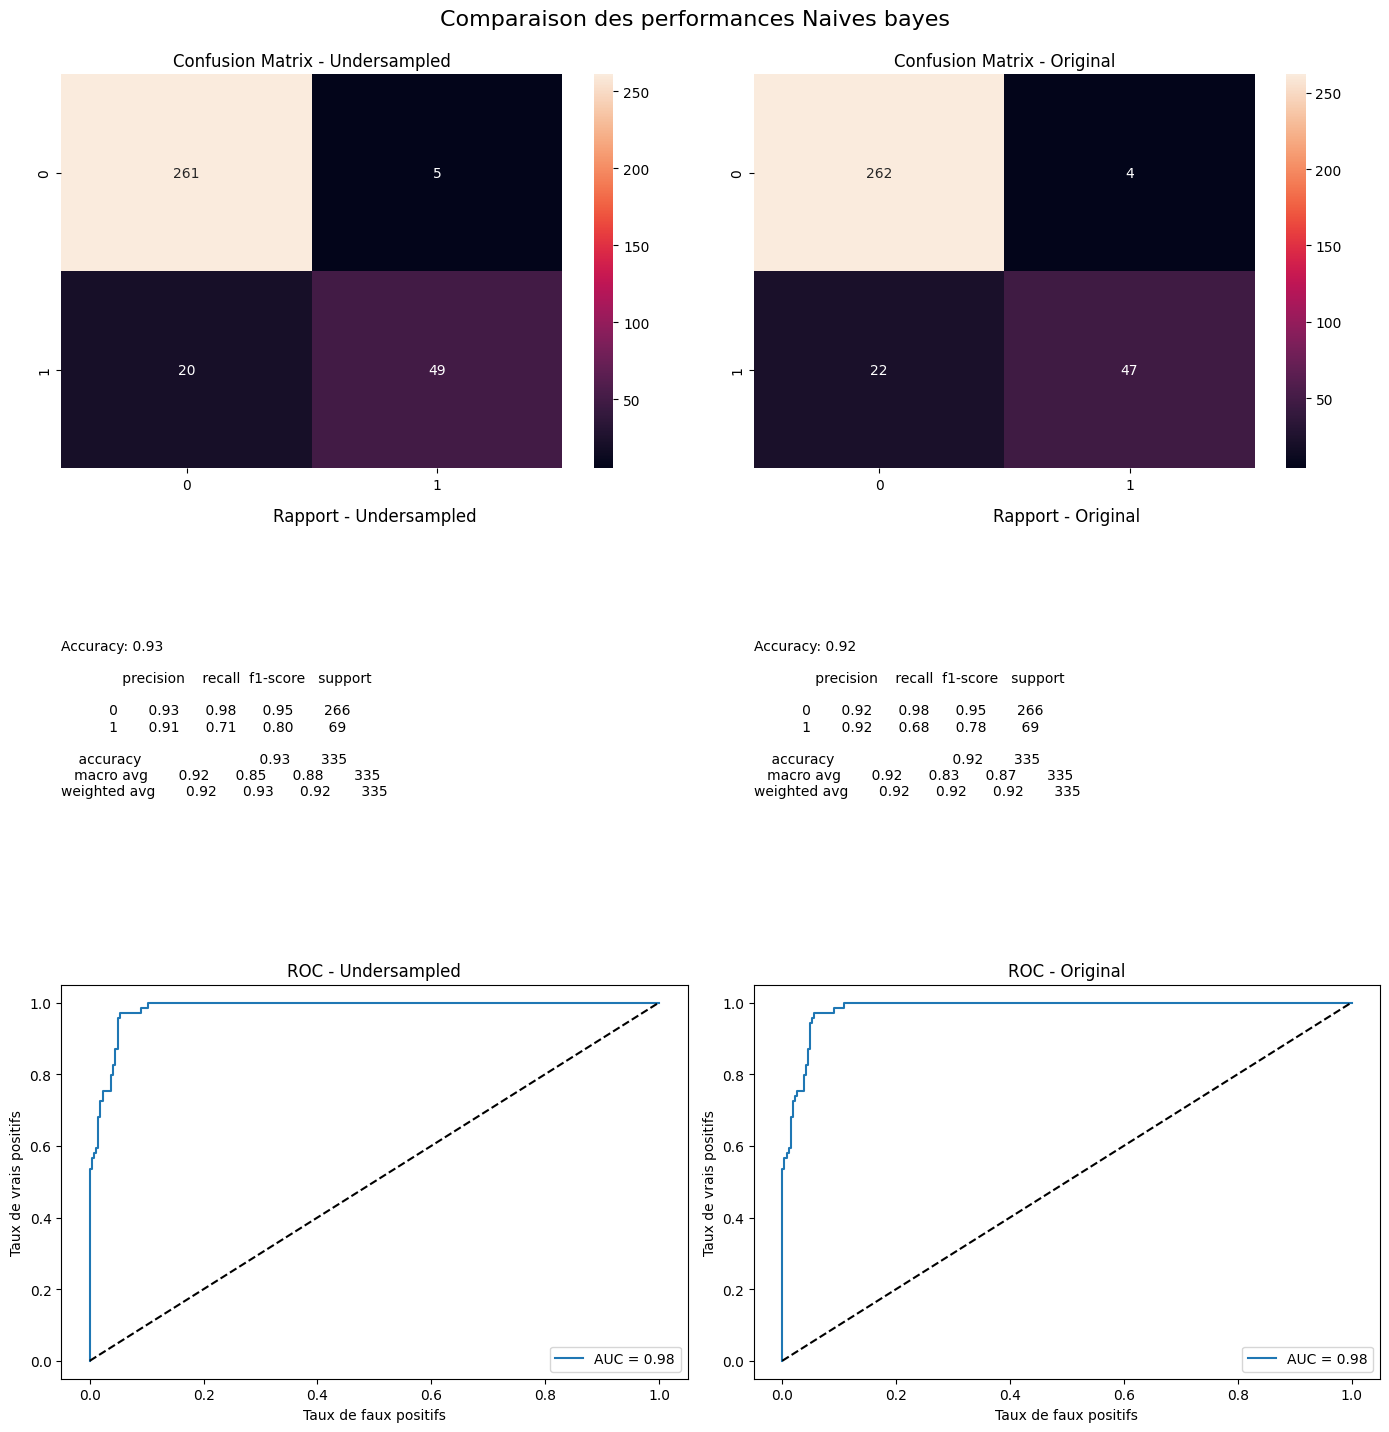

In [14]:
resampled_data_dict = {}

for undersampler in undersampler_dict.keys():
    print("Méthode d'under-sampling : ", undersampler)
    
    # Resampling des données
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)

    # Conversion en DataFrame si nécessaire
    if not isinstance(X_resampled, pd.DataFrame):
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    if isinstance(y_resampled, pd.DataFrame):
        y_resampled = y_resampled.iloc[:, 0]
    else:
        y_resampled = pd.Series(y_resampled, name='smoker')
    
    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Sauvegarde pour éventuelle réutilisation
    resampled_data_dict[undersampler] = data_resampled
    
    # Visualisation comparative
    compare_smoker_distribution(data, data_resampled, title_suffix=f"({undersampler})")
    compare_pca_oversampling(data, {undersampler: data_resampled})

    # Comparaison de performance tout de suite après la visualisation
    print(f"\n####### COMPARAISON PERFORMANCE - MÉTHODE : {undersampler.upper()} #######")
    X_train_resampled = data_resampled.drop(columns='smoker')
    y_train_resampled = data_resampled['smoker']

    compare_Naives_bayes_performance(
        X_train_orig=X_train, y_train_orig=y_train,
        X_train_res=X_train_resampled, y_train_res=y_train_resampled,
        X_test=X_test, y_test=y_test
    )


## Xgboost
### requilibrage et control de l'impact sur le modeles 

Méthode d'under-sampling :  random


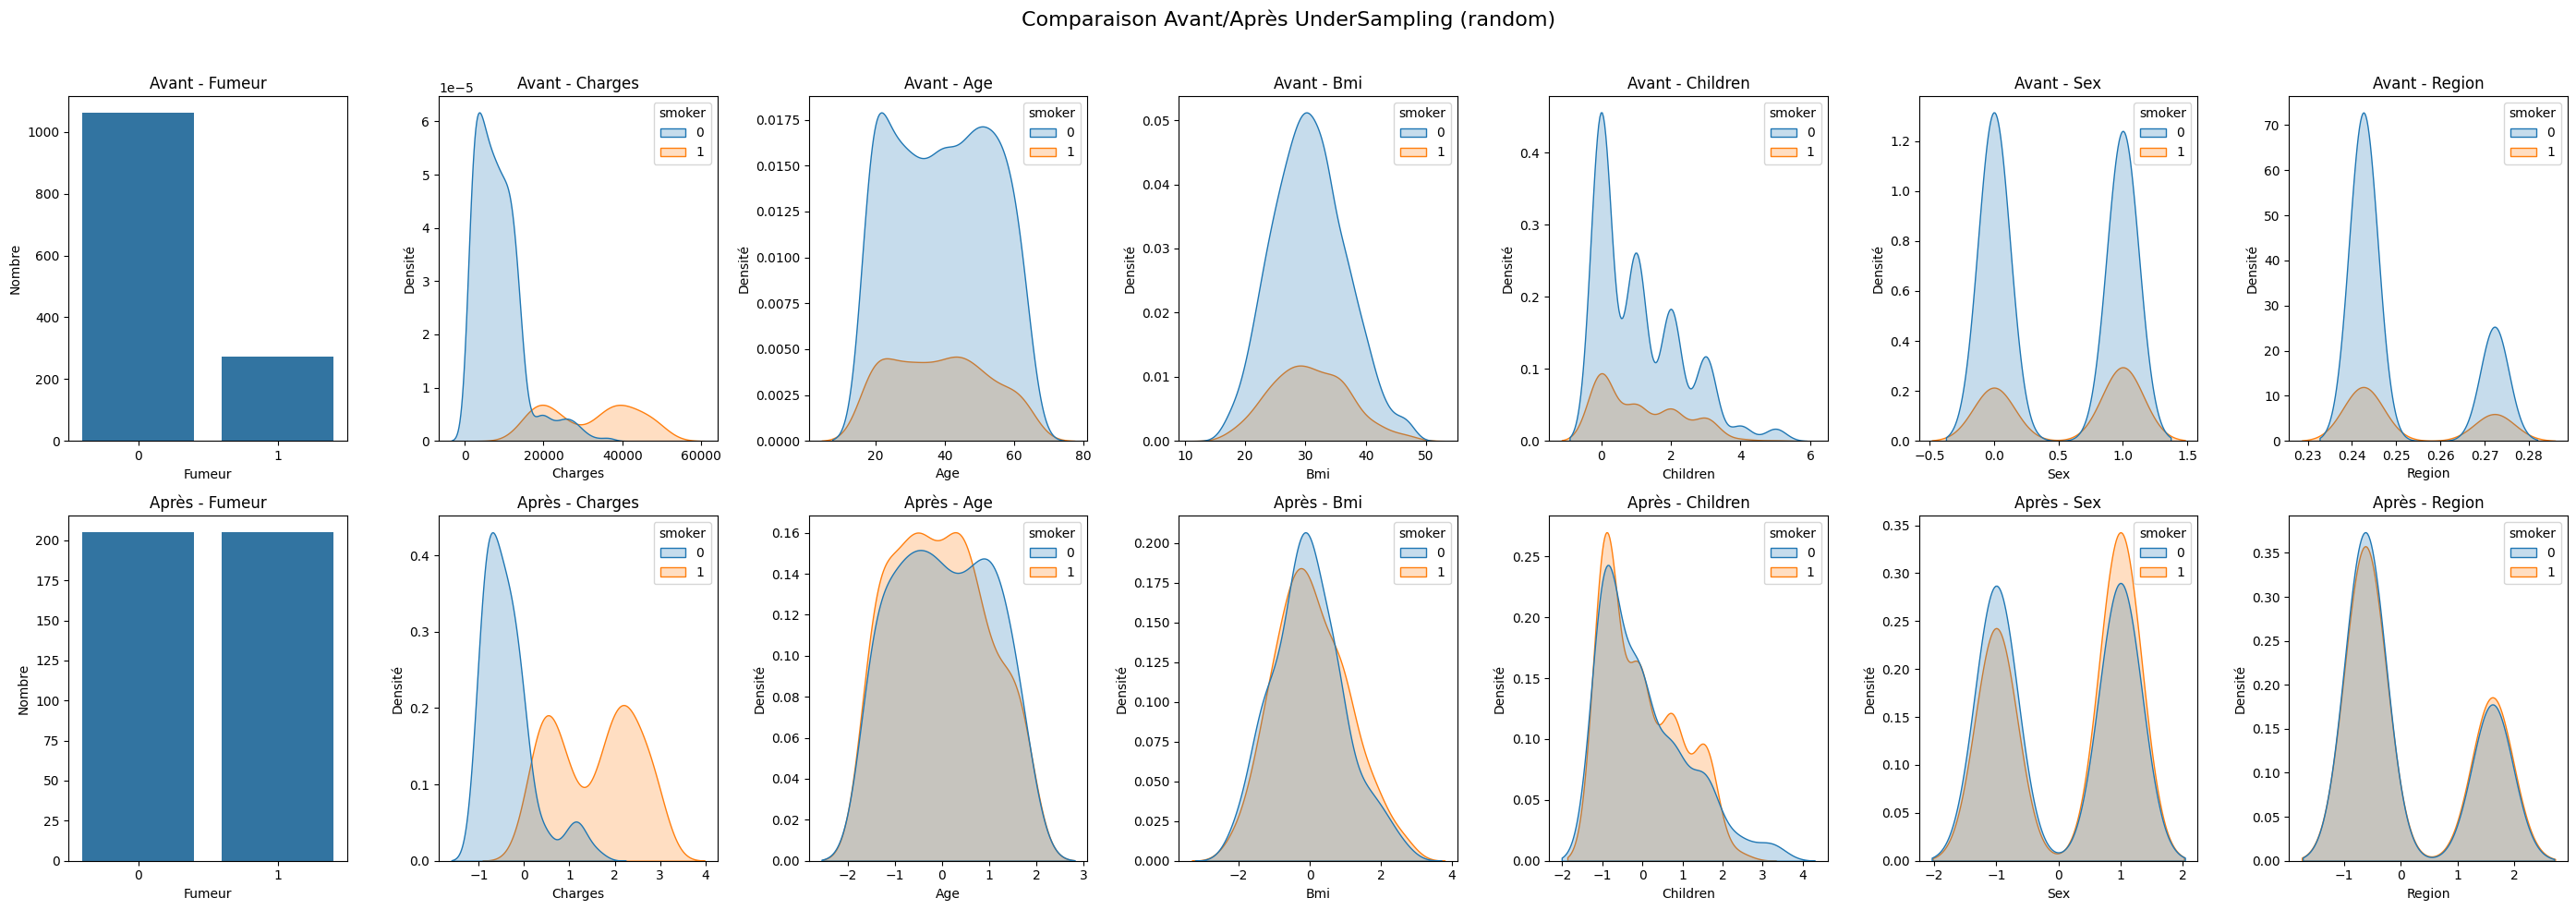

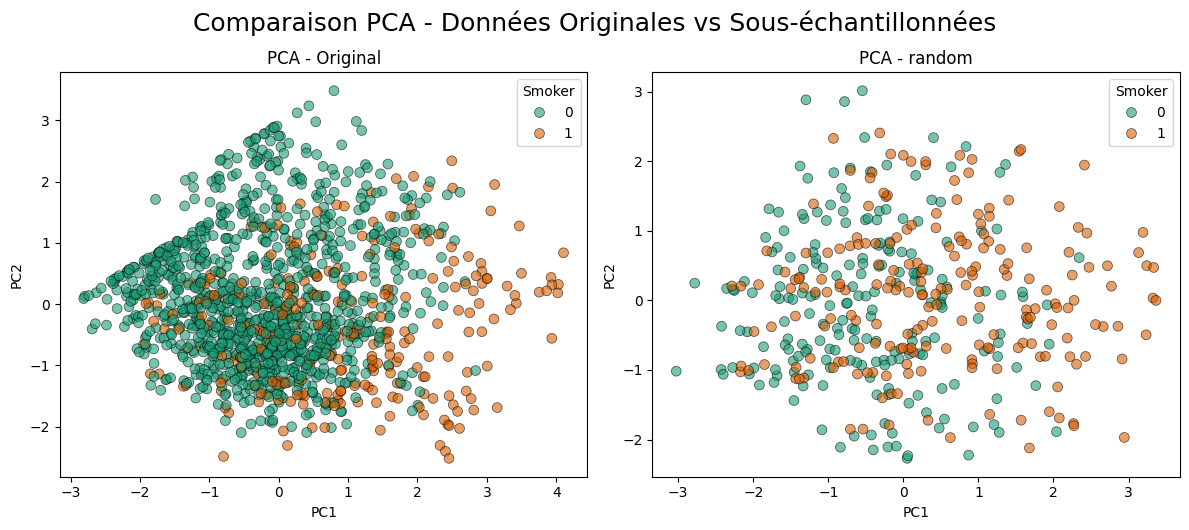


####### COMPARAISON PERFORMANCE - MÉTHODE : RANDOM #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.9804878048780488


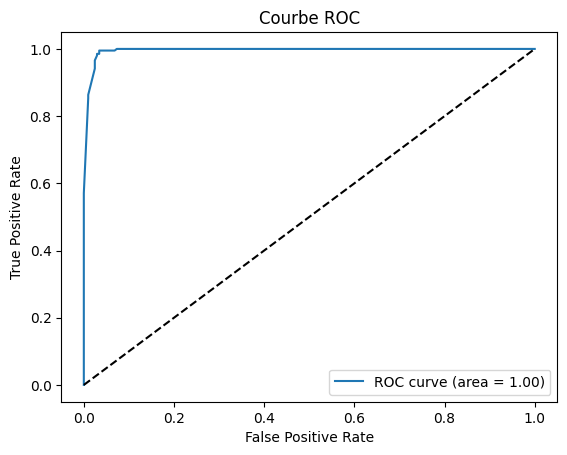

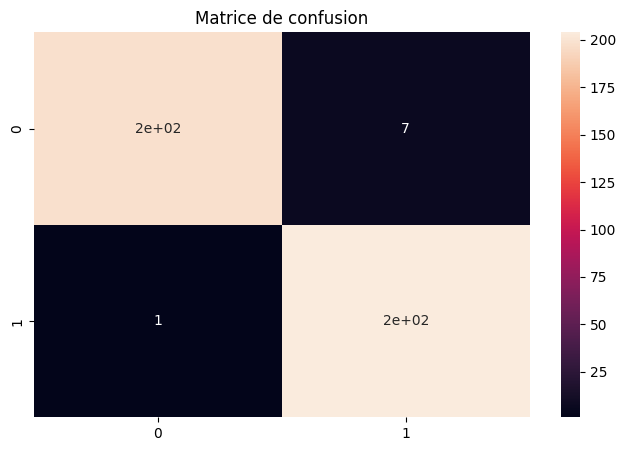

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       205
           1       0.97      1.00      0.98       205

    accuracy                           0.98       410
   macro avg       0.98      0.98      0.98       410
weighted avg       0.98      0.98      0.98       410


=== Entraînement sur données originales ===
Accuracy :  0.9630738522954092


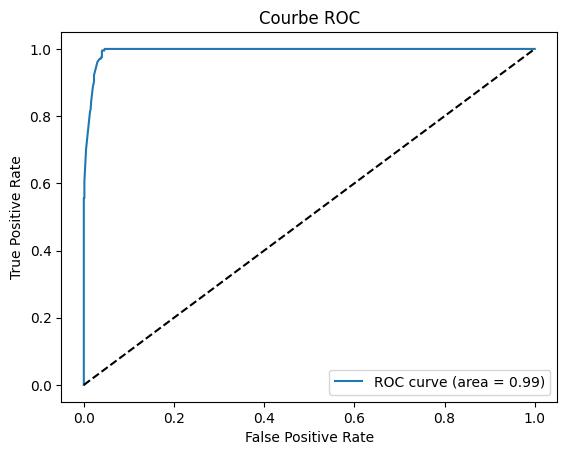

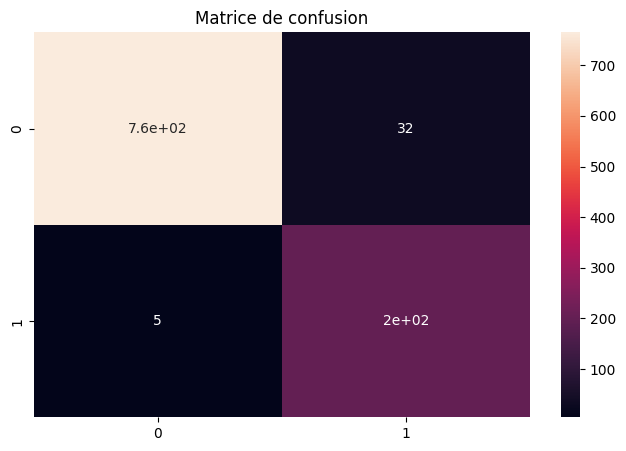

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       797
           1       0.86      0.98      0.92       205

    accuracy                           0.96      1002
   macro avg       0.93      0.97      0.95      1002
weighted avg       0.97      0.96      0.96      1002



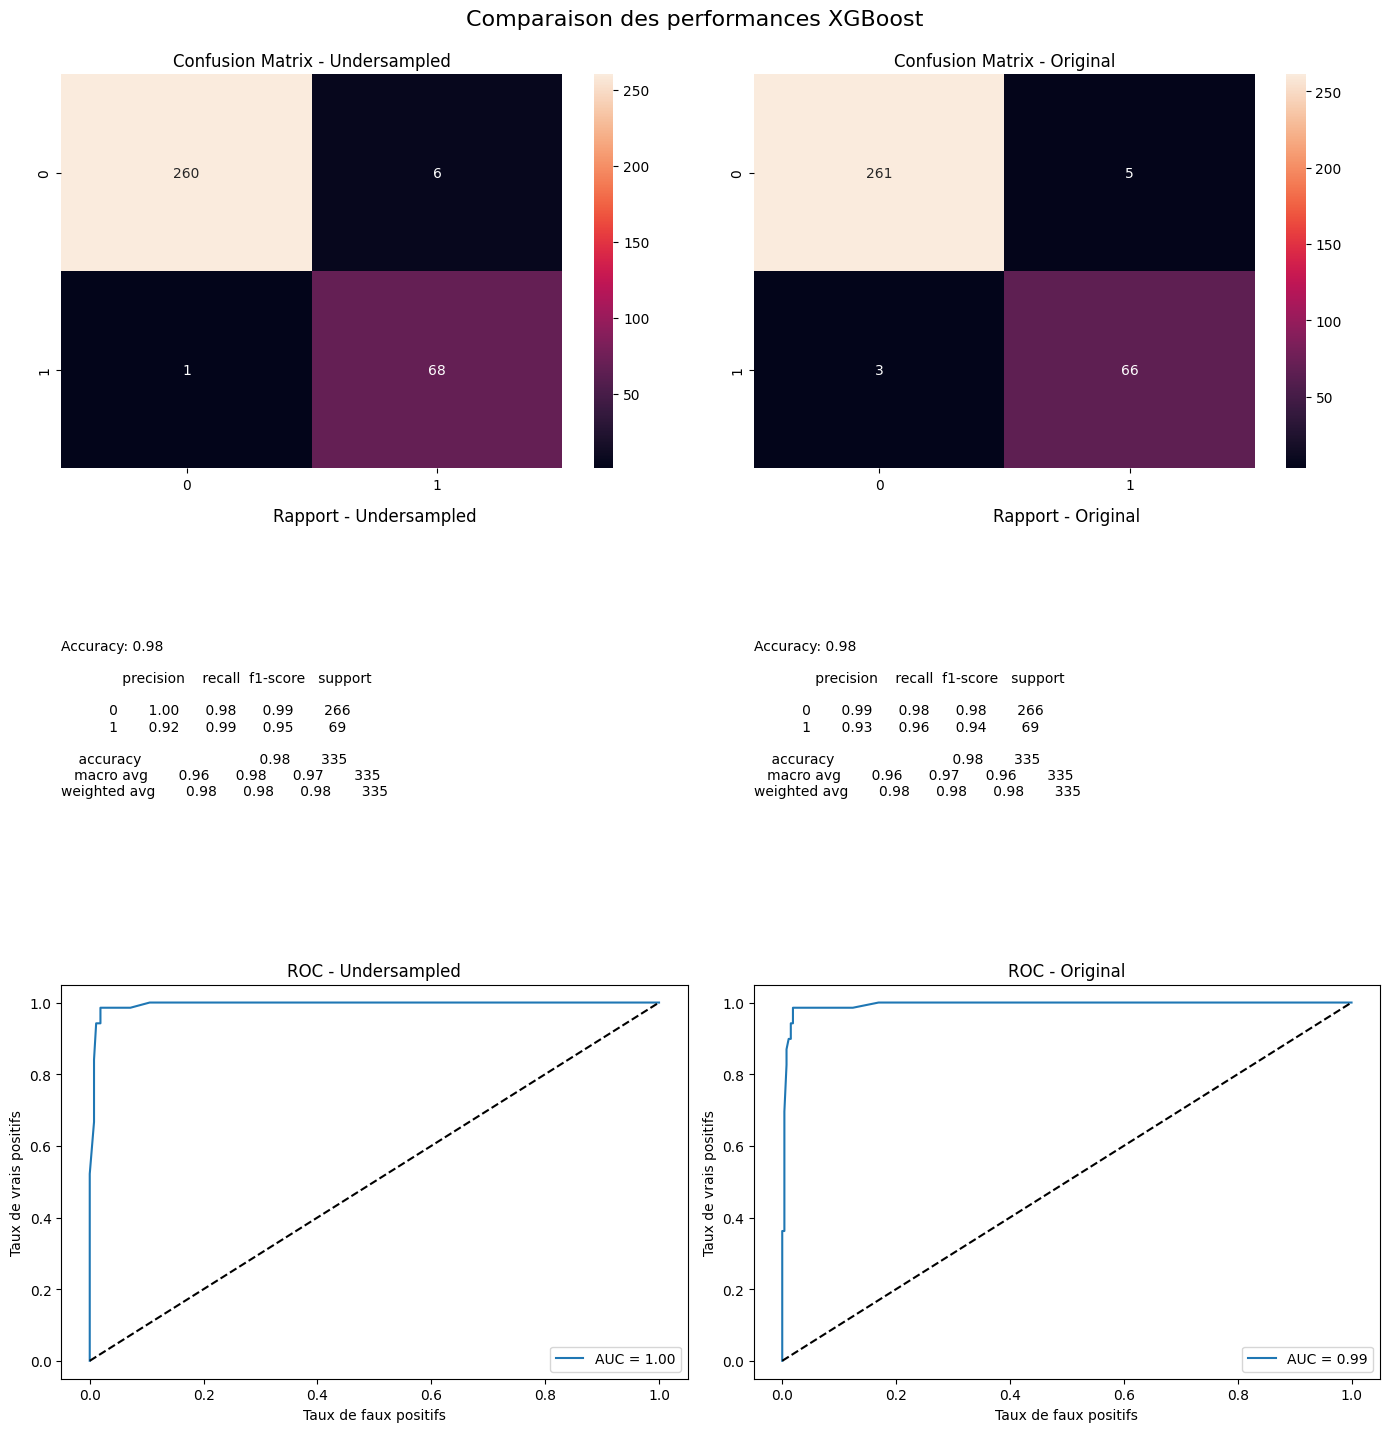

Méthode d'under-sampling :  cnn


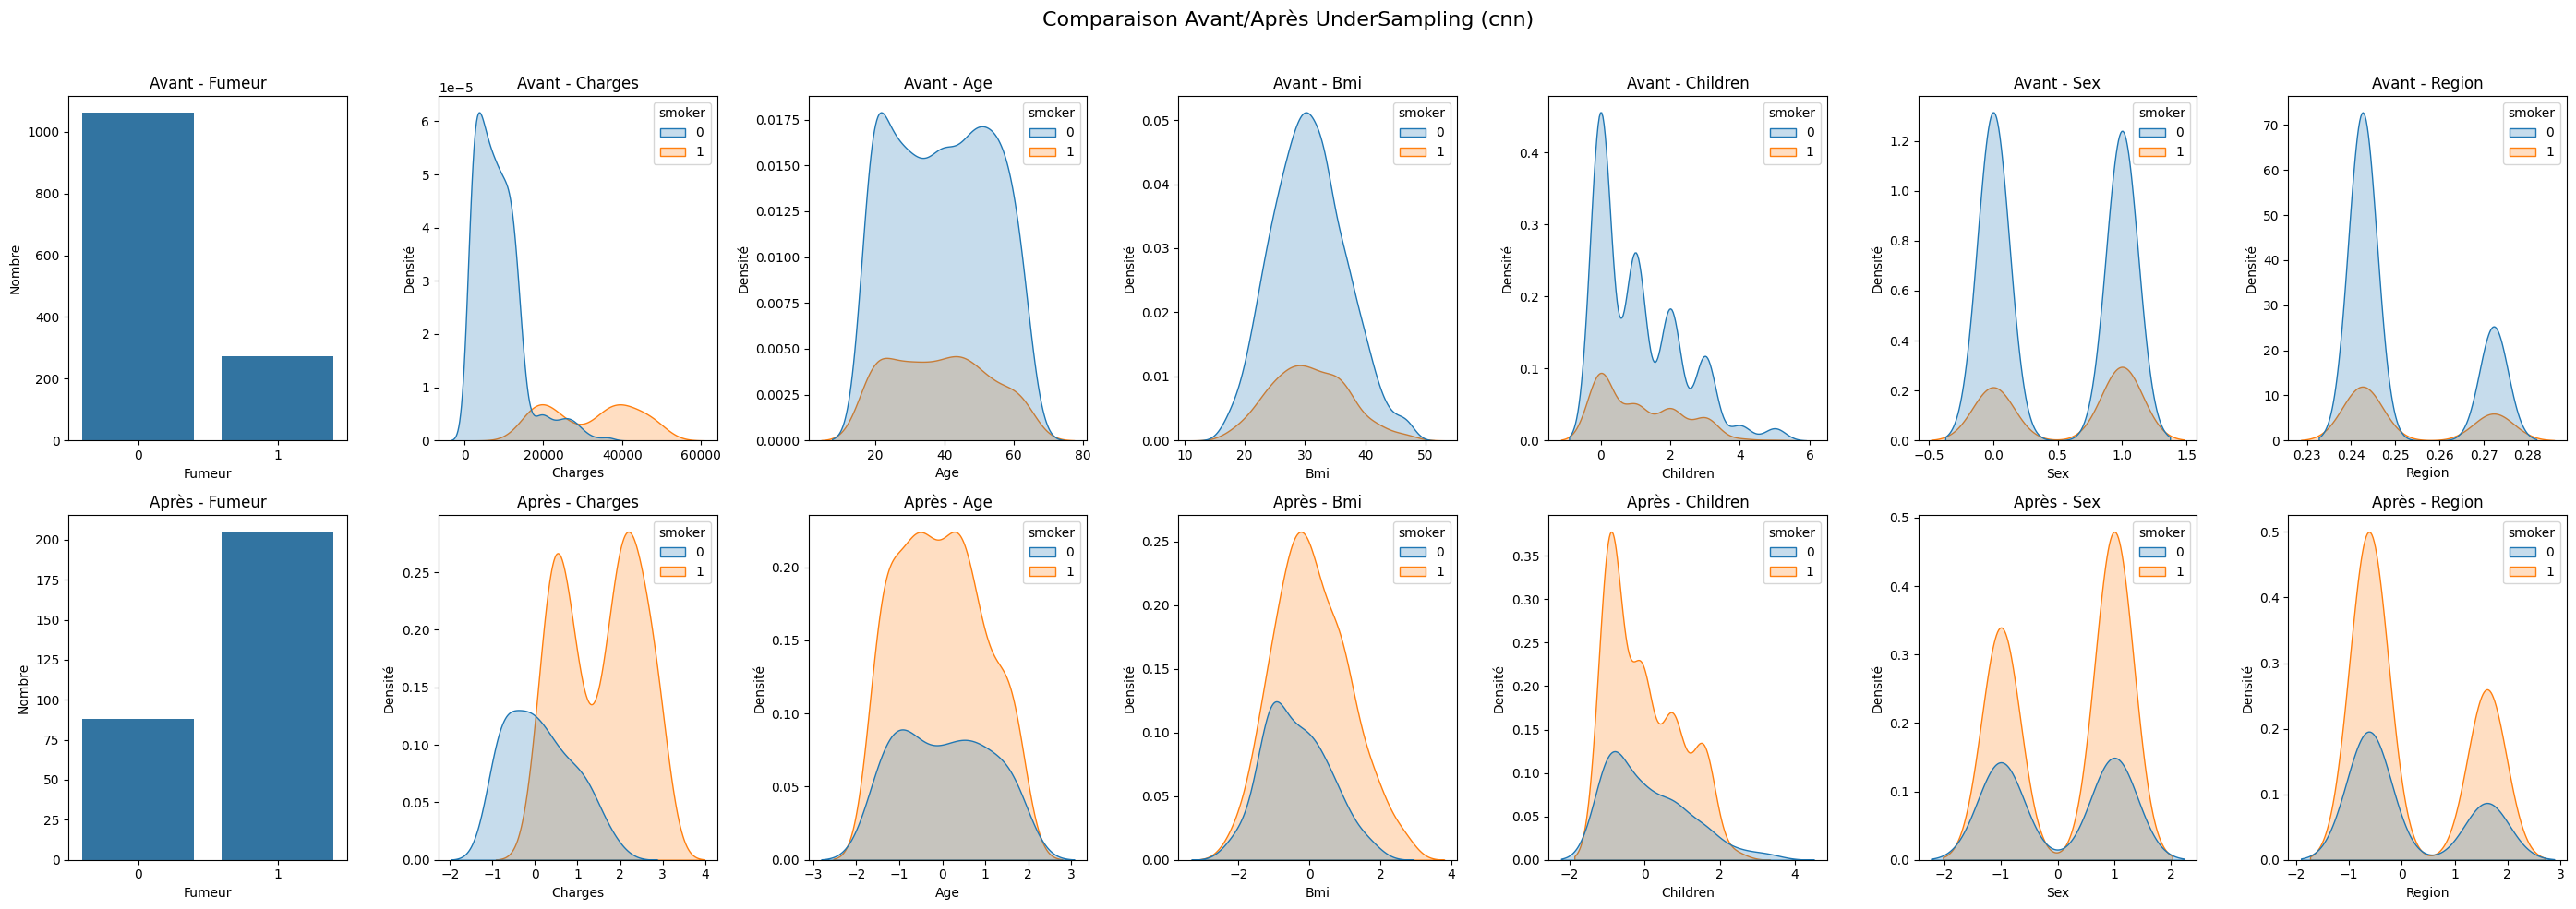

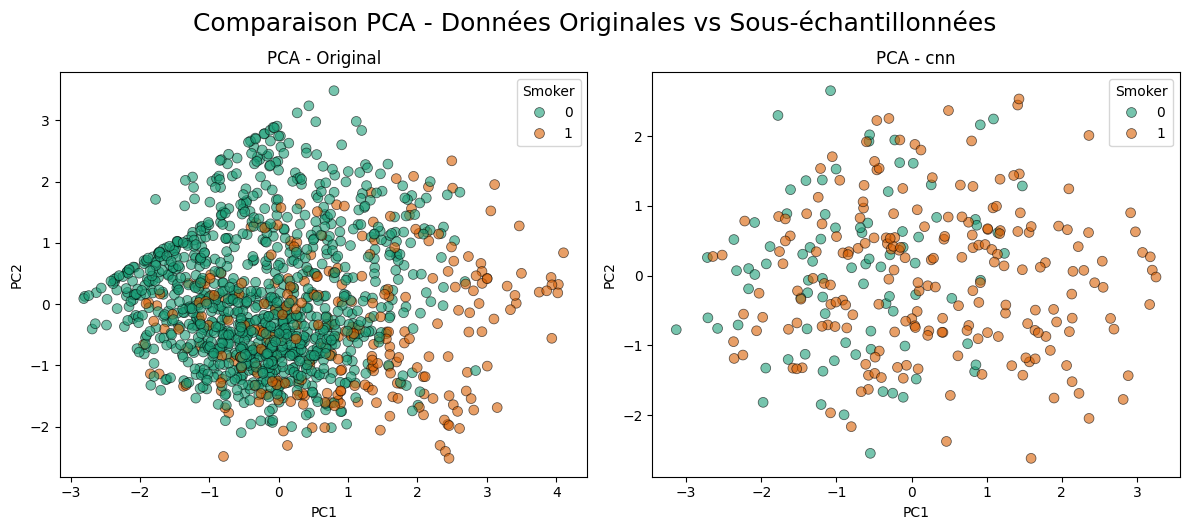


####### COMPARAISON PERFORMANCE - MÉTHODE : CNN #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.9180887372013652


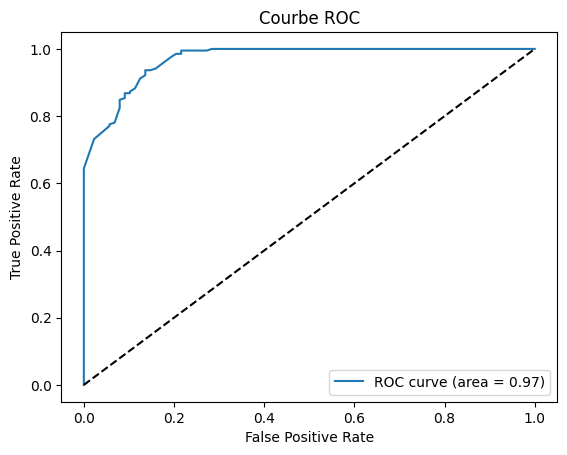

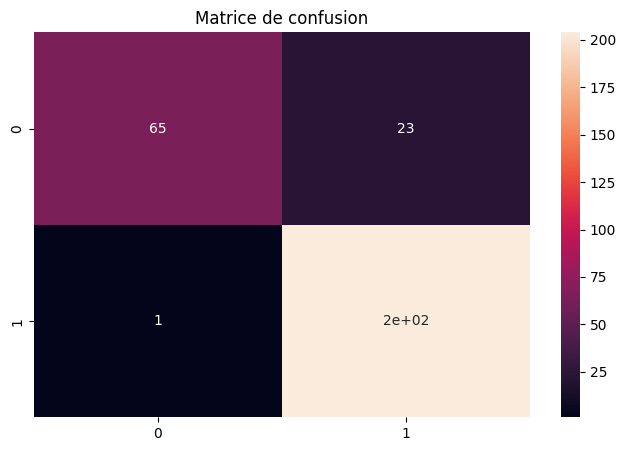

              precision    recall  f1-score   support

           0       0.98      0.74      0.84        88
           1       0.90      1.00      0.94       205

    accuracy                           0.92       293
   macro avg       0.94      0.87      0.89       293
weighted avg       0.92      0.92      0.91       293


=== Entraînement sur données originales ===
Accuracy :  0.9630738522954092


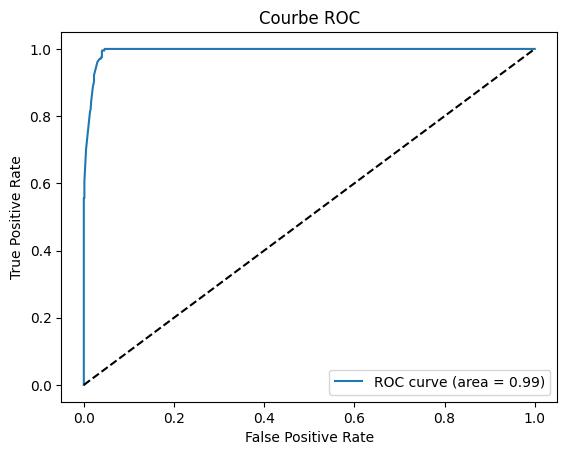

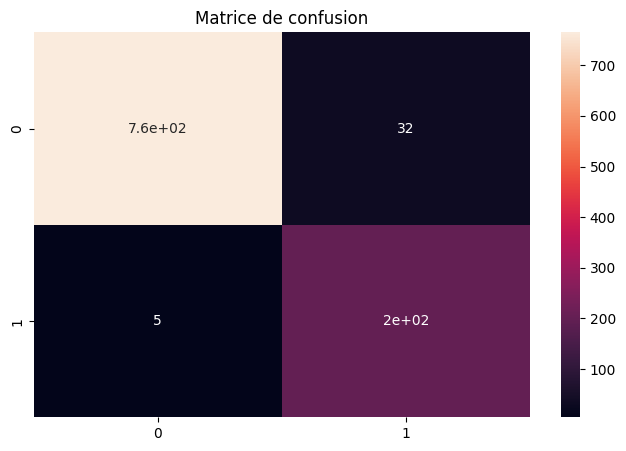

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       797
           1       0.86      0.98      0.92       205

    accuracy                           0.96      1002
   macro avg       0.93      0.97      0.95      1002
weighted avg       0.97      0.96      0.96      1002



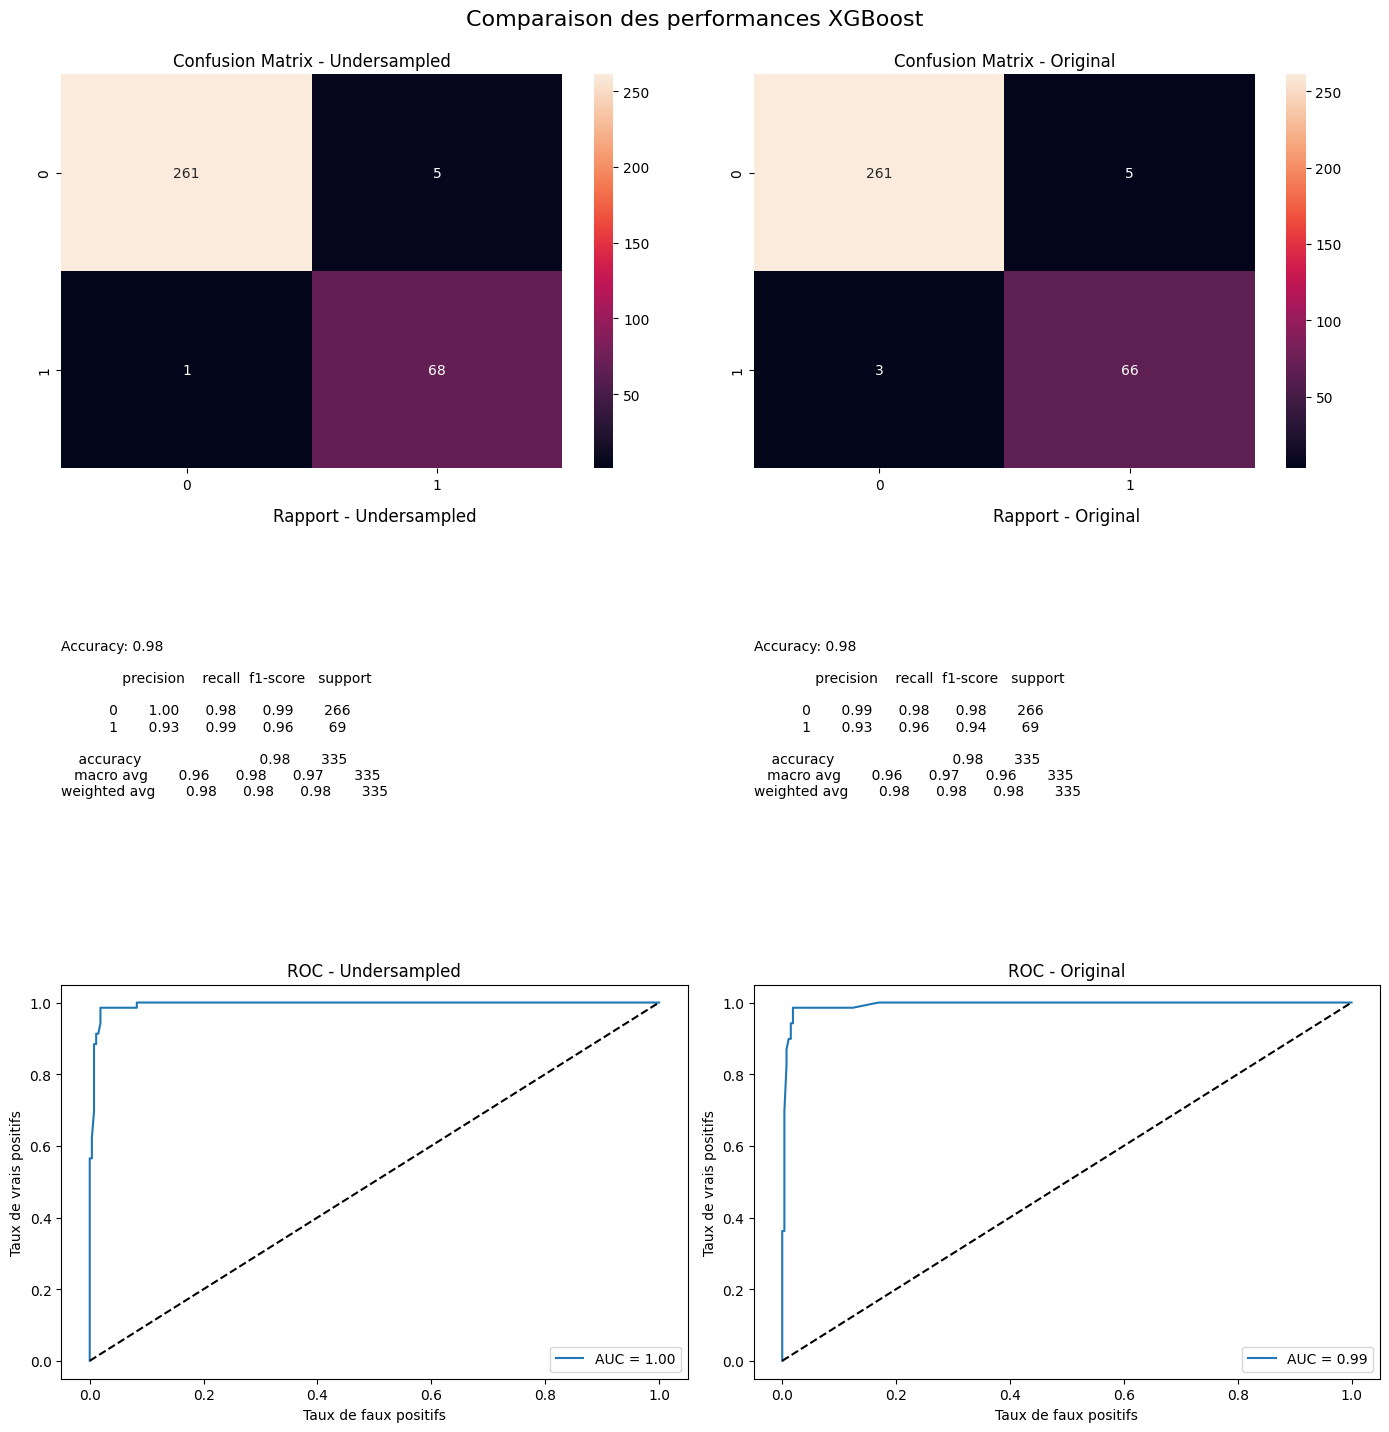

Méthode d'under-sampling :  tl


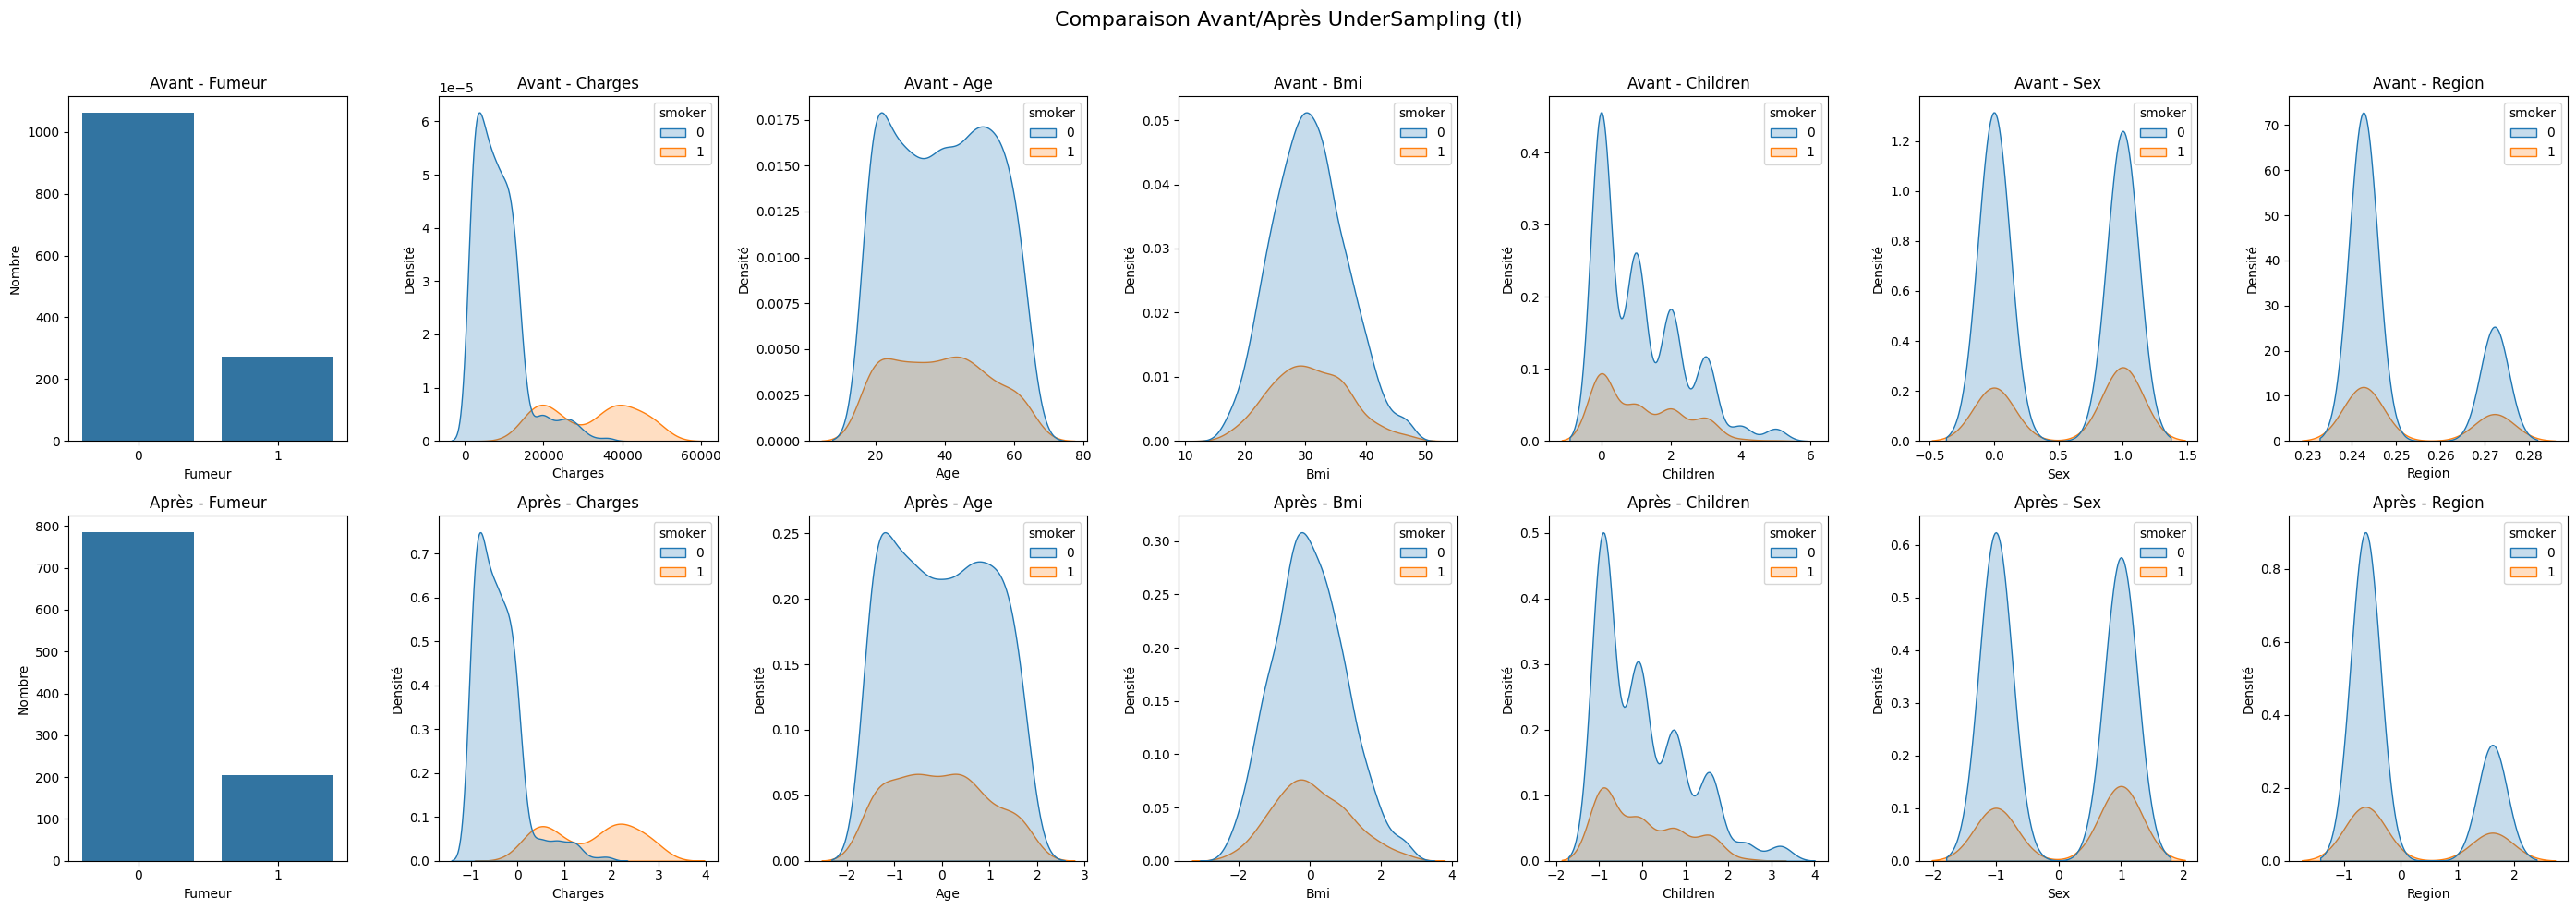

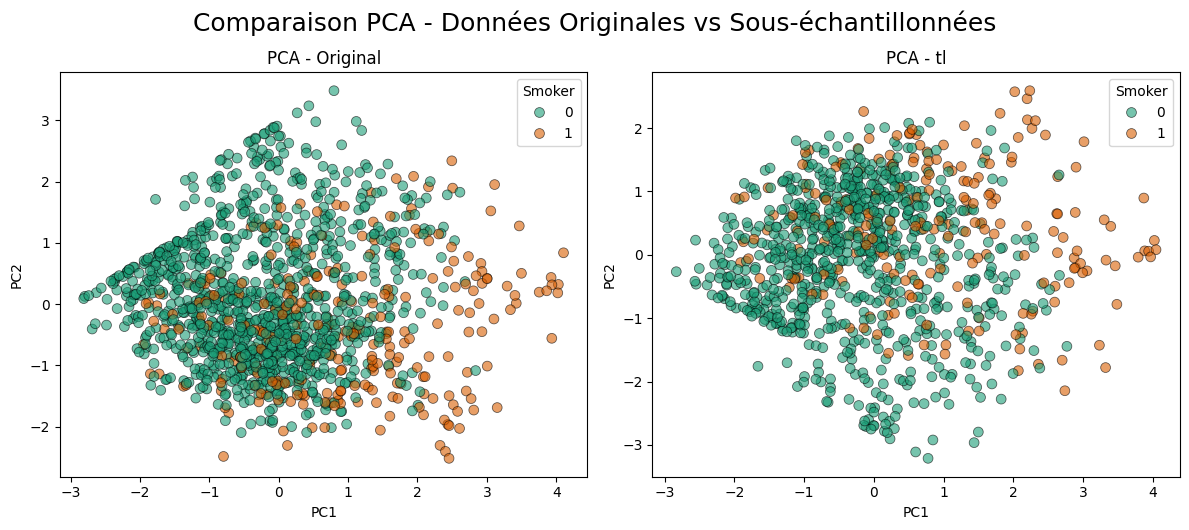


####### COMPARAISON PERFORMANCE - MÉTHODE : TL #######
=== Entraînement sur données sous-échantillonnées ===
Accuracy :  0.9777777777777777


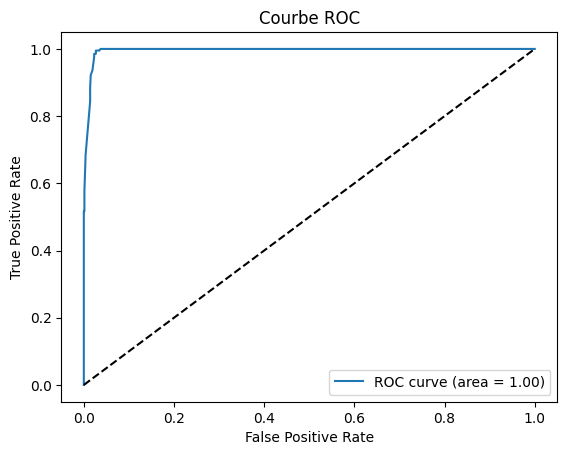

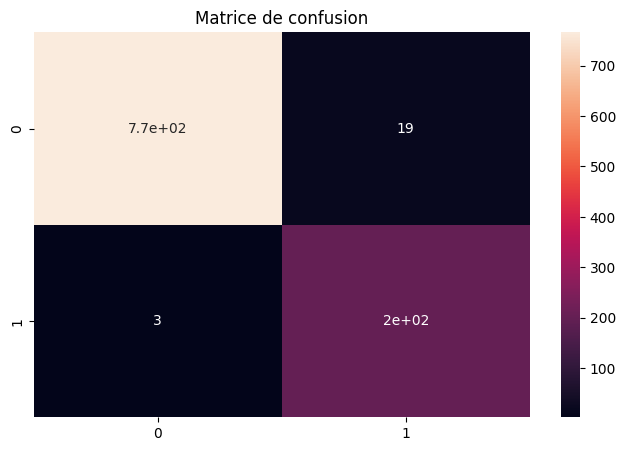

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       785
           1       0.91      0.99      0.95       205

    accuracy                           0.98       990
   macro avg       0.96      0.98      0.97       990
weighted avg       0.98      0.98      0.98       990


=== Entraînement sur données originales ===
Accuracy :  0.9630738522954092


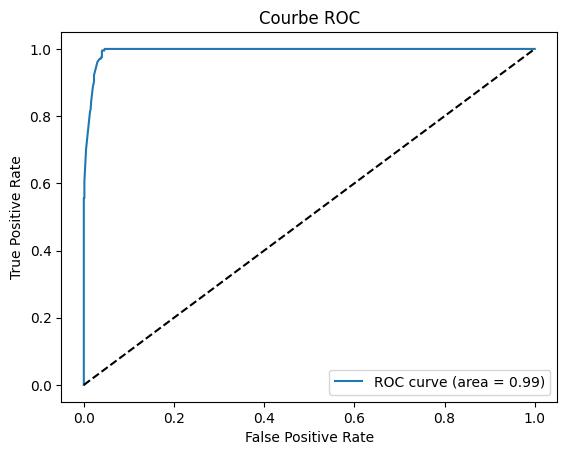

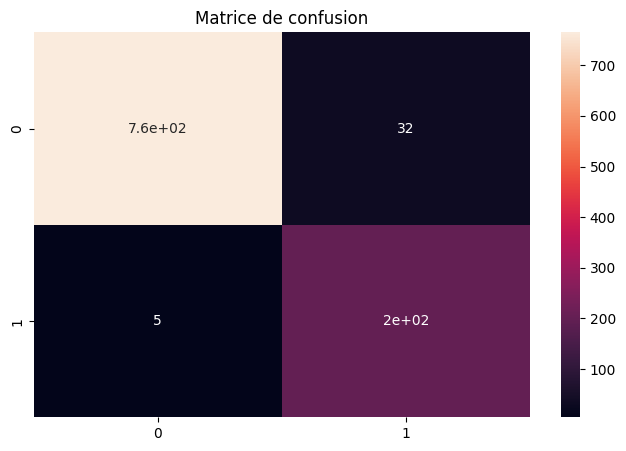

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       797
           1       0.86      0.98      0.92       205

    accuracy                           0.96      1002
   macro avg       0.93      0.97      0.95      1002
weighted avg       0.97      0.96      0.96      1002



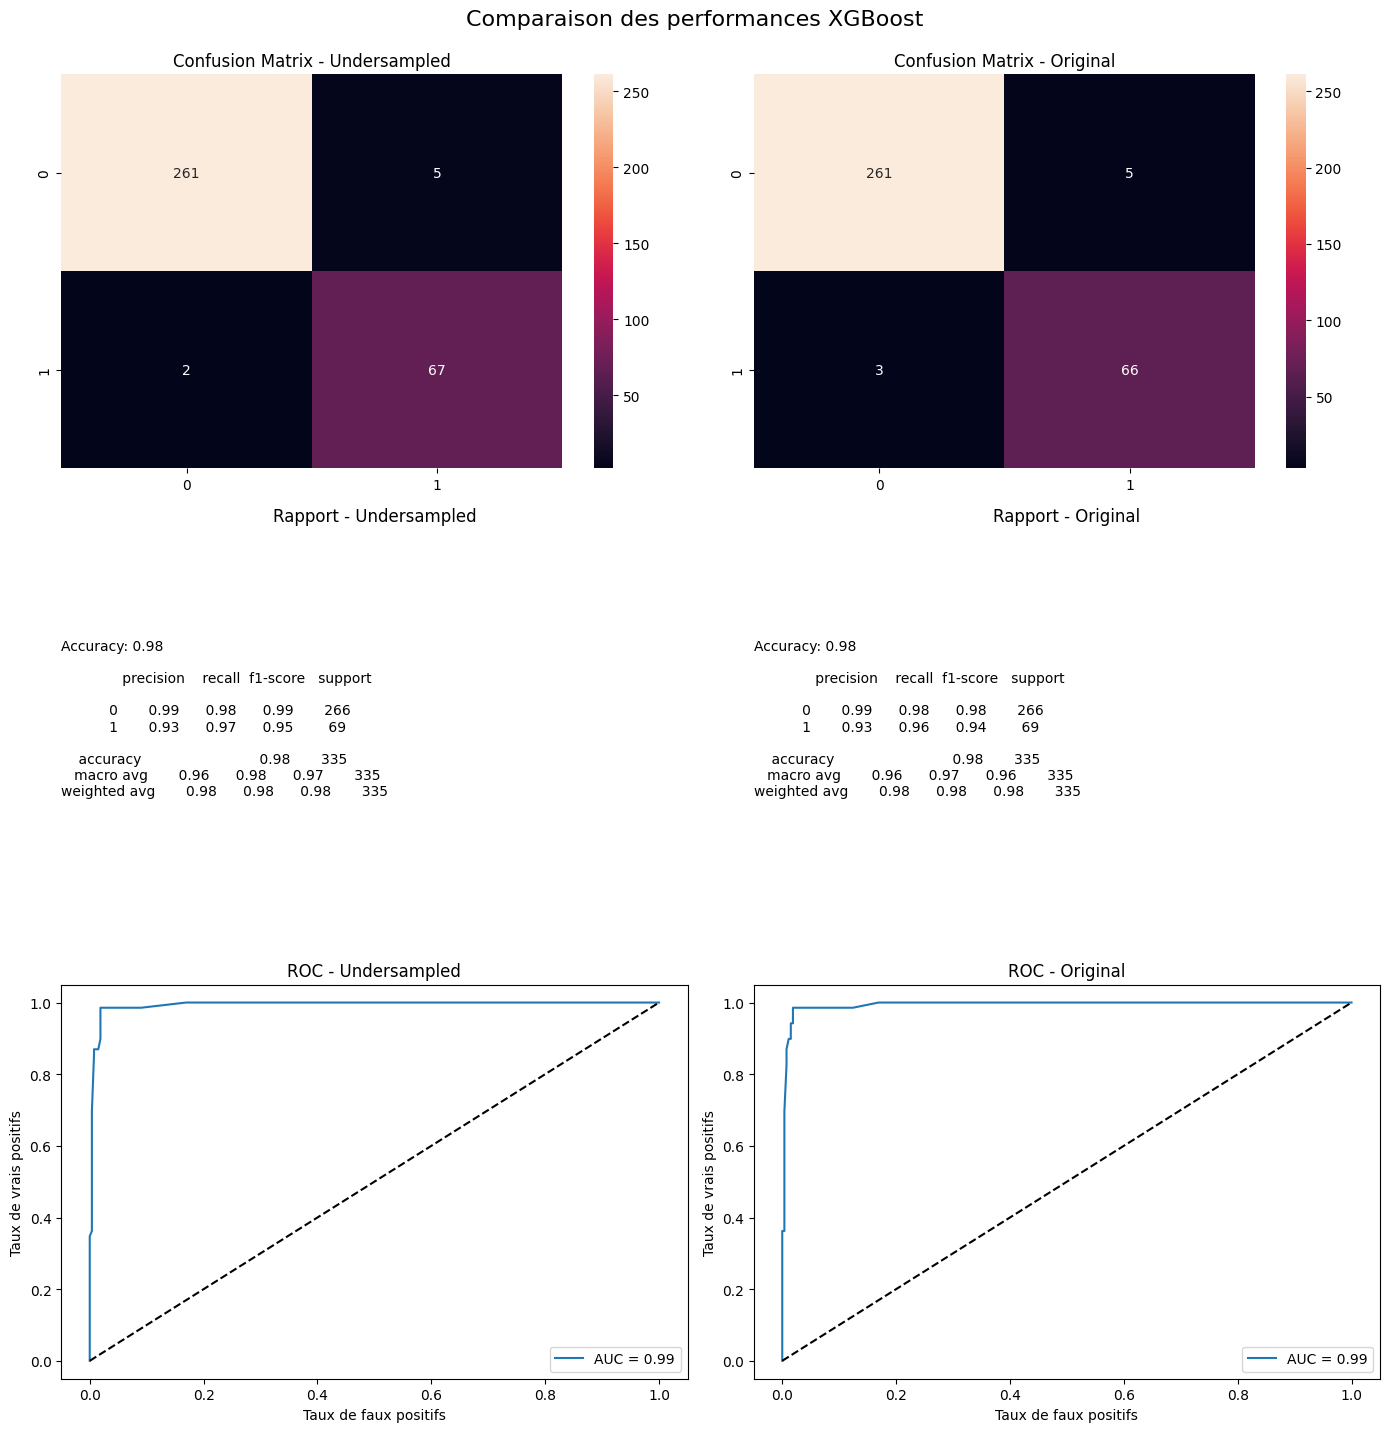

In [15]:
resampled_data_dict = {}

for undersampler in undersampler_dict.keys():
    print("Méthode d'under-sampling : ", undersampler)
    
    # Resampling des données
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)

    # Conversion en DataFrame si nécessaire
    if not isinstance(X_resampled, pd.DataFrame):
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    if isinstance(y_resampled, pd.DataFrame):
        y_resampled = y_resampled.iloc[:, 0]
    else:
        y_resampled = pd.Series(y_resampled, name='smoker')
    
    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Sauvegarde pour éventuelle réutilisation
    resampled_data_dict[undersampler] = data_resampled
    
    # Visualisation comparative
    compare_smoker_distribution(data, data_resampled, title_suffix=f"({undersampler})")
    compare_pca_oversampling(data, {undersampler: data_resampled})

    # Comparaison de performance tout de suite après la visualisation
    print(f"\n####### COMPARAISON PERFORMANCE - MÉTHODE : {undersampler.upper()} #######")
    X_train_resampled = data_resampled.drop(columns='smoker')
    y_train_resampled = data_resampled['smoker']

    compare_xgboost_performance(
        X_train_orig=X_train, y_train_orig=y_train,
        X_train_res=X_train_resampled, y_train_res=y_train_resampled,
        X_test=X_test, y_test=y_test
    )
